# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** Beatriz Borges, Lara Orlandic, Nikolina Tomic

**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation 

The goal of this exercise is to explore the power of basic image processing methods in order to segment a brain from a single brain-slice MRI image. One can observe two main segments in the image: a black background and a brain in the foreground. There are then three meaningful parts of the foregroud: brain tissue; CSF-cerebrospinal fluid in cerebral ventricles, sulci and around the brain; and skull as a bone structure that surrounds the full anatomy of brain. We first remove the cerebrospinal fluid and the background by finding an optimal threshold, and we then examine other methods to segment the brain tissue. Once we extract the brain, we perform segmentation of gray and white matter of the brain. 

Here we ilustrate our final results:

<br/>

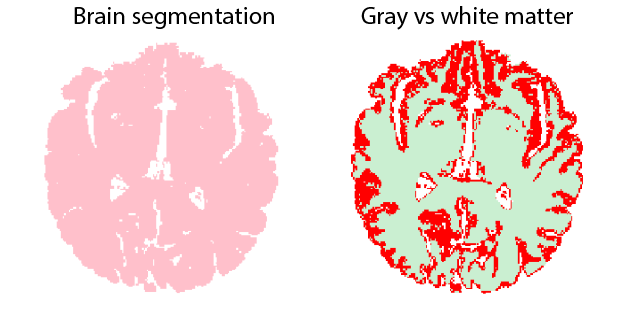

<br/><hr/>

### 1.1 Brain image visualization

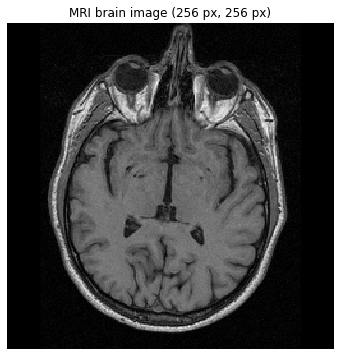

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

In [3]:
# import all libraries used throughout the notebook
import cv2
import math
import numpy as np
from PIL import Image

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
from scipy.stats import norm
from scipy.ndimage import measurements

import skimage.io
from skimage import data, feature, filters, restoration, exposure, morphology, measure

from skimage.morphology import disk
from skimage.exposure import histogram

from skimage.util import img_as_ubyte
from skimage.color import label2rgb, rgb2hsv
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu, rank, sobel
from skimage.morphology import closing, square
from skimage.segmentation import clear_border, watershed, chan_vese

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

#### Helper functions
First, we define some helpful functions for manipulating and vizualizing images.

In [4]:
def plot_brain(brain_image,caption):
    """Plot a brain image"""
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(brain_image, cmap='gray')
    ax.set_title(caption)
    ax.axis('off')
    plt.show()
    
def test_all_filters(brain_im):
    """Test all of the filters on an image to view their different effects on noise 
    reduction and contour enhancement"""
    # median filter
    med_brain = filters.median(brain_im)
    
    # Wiener filter
    psf = np.ones((5, 5)) / 25
    wiener_brain = restoration.wiener(brain_im, psf, 0.05, clip=False)
    
    # Sobel filter
    sobel_brain = filters.sobel(brain_im)
    
    # Schaar filter
    scharr_brain = filters.scharr(brain_im)
    
    # histogram equalization
    equ = cv2.equalizeHist(brain_im)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0,0].imshow(med_brain, cmap = 'gray')
    axs[0,0].set_title("Median Filter")
    axs[0,0].axis('off')
    
    axs[0,1].imshow(wiener_brain, cmap = 'gray')
    axs[0,1].set_title("Wiener Filter")
    axs[0,1].axis('off')
    
    axs[0,2].imshow(sobel_brain, cmap = 'gray')
    axs[0,2].set_title("Sobel Filter")
    axs[0,2].axis('off')
    
    axs[1,0].imshow(scharr_brain, cmap = 'gray')
    axs[1,0].set_title("Scharr Filter")
    axs[1,0].axis('off')
    
    axs[1,1].imshow(equ, cmap = 'gray')
    axs[1,1].set_title("Histogram Equalization")
    axs[1,1].axis('off')
    
    axs[1,2].axis('off')
    plt.show()
    
def all_contour_detection(brain_im):
    """Test all contour detection techniques simultaneously on one brain image"""
    # Canny method
    canny_brain = feature.canny(brain_im)
    
    # local gradient
    grad = filters.rank.gradient(skimage.util.img_as_ubyte(brain_im), disk(1))
    
    # contour enhancing highpass filters
    kernel1 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    kernel2 = np.array([[-1, -1, -1],
                   [-1,  9, -1],
                   [-1, -1, -1]])
    kernel3 = np.array([[1, -2, 1],
                   [-2,  5, -2],
                   [1, -2, 1]])
    highpass1 = ndi.convolve(brain_im, kernel1)
    highpass2 = ndi.convolve(brain_im, kernel2)
    highpass3 = ndi.convolve(brain_im, kernel3)
    
    # Laplace contour detection
    lap_brain = filters.laplace(brain_im)
    
    # Laplacian of Gaussian
    LoG = ndi.gaussian_laplace(brain_im, sigma=1.5)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs[0,0].imshow(canny_brain, cmap = 'gray')
    axs[0,0].set_title("Canny Filter")
    axs[0,0].axis('off')
    
    axs[0,1].imshow(grad, cmap = 'gray')
    axs[0,1].set_title("Local Gradient of the Brain")
    axs[0,1].axis('off')
    
    axs[0,2].imshow(highpass1, cmap = 'gray')
    axs[0,2].set_title("Highpass Contour Enhancement #1")
    axs[0,2].axis('off')
    
    axs[0,3].imshow(highpass2, cmap = 'gray')
    axs[0,3].set_title("Highpass Contour Enhancement #2")
    axs[0,3].axis('off')
    
    axs[1,0].imshow(highpass3, cmap = 'gray')
    axs[1,0].set_title("Highpass Contour Enhancement #3")
    axs[1,0].axis('off')
    
    axs[1,1].imshow(lap_brain, cmap = 'gray')
    axs[1,1].set_title("Laplacian")
    axs[1,1].axis('off')
    
    axs[1,2].imshow(LoG, cmap = 'gray')
    axs[1,2].set_title("Laplacian of Gaussian")
    axs[1,2].axis('off')
    
    axs[1,3].axis('off')
    plt.show()

def get_thresholded_brain(brain_im, multiplier):
    """Isolate the brain pixels from the background and skull by taking only pixel values 
    within one standard deviation of the mean of gray pixels, based on Gaussian curve fitting"""
    # best fit of data
    n, bins, patches = plt.hist(brain_im.ravel(),60, density=1)
    plt.close()
    separator = bins[1:][np.argmin(n[bins[1:] < 25])]
    datos = brain_im.ravel()
    datos2 = datos[datos > separator]
    (mu2, sigma2) = norm.fit(datos2)
    
    # threshold brain based on second Gaussian
    lower_lim = mu2 - multiplier*sigma2
    upper_lim = mu2 + multiplier*sigma2
    mask = (brain_im > lower_lim) & (brain_im < upper_lim)
    not_mask = (brain_im < lower_lim) | (brain_im > upper_lim)
    brain_with_zero_background = brain_im.copy()
    brain_with_zero_background[not_mask] = 0;
    return brain_with_zero_background, mask
    
def getNumberOfBrainPixels(mask):
    """Determine the number of pixels belonging to the brain in the image"""
    brain_pix = mask.sum()
    total_pix = np.prod(mask.shape)
    print("The brain region size in pixels: {0}".format(brain_pix))
    percent = brain_pix*100/total_pix
    print("The brain region percent of total image: {:.2f}%".format(percent))
    return brain_pix, percent
    
def visualizeMathematicalMorphology(mask):
    """Visualize the effects of all mathematical morphology operators on a single brain image mask"""
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    axes[0].imshow(ndi.binary_dilation(mask), cmap='gray')
    axes[0].set_title("Dilation")
    axes[1].imshow(ndi.binary_erosion(mask), cmap='gray')
    axes[1].set_title("Erosion")
    axes[2].imshow(ndi.binary_opening(mask), cmap='gray')
    axes[2].set_title("Opening")
    axes[3].imshow(ndi.binary_closing(mask), cmap='gray')
    axes[3].set_title("Closing")
    plt.show()
    
def show_results(mask,image_title):
    """ This function takes a binary mask as an input and plots two resulting images.
    Once you segment the brain, then your image BRAIN must be black, in white background.
    Then just copy this 3 lines: 
    mm=np.ones((256,256),np.uint8)
    mm[BRAIN==0]=0
    show_results(mm)"""

    data_base_path = os.path.join(os.pardir, 'data')
    data_folder = 'lab-01-data'
    tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
    with tarfile.open(tar_path, mode='r:gz') as tar:
        tar.extractall(path=data_base_path)

    # Load image
    data_path = os.path.join(data_base_path, data_folder)
    img = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

    edge_sobel = filters.roberts(mask)    
    ind = (edge_sobel != 0)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb[np.where(ind==1)[0], np.where(ind==1)[1],0] = 207
    img_rgb[np.where(ind==1)[0], np.where(ind==1)[1],1] = 255
    img_rgb[np.where(ind==1)[0], np.where(ind==1)[1],2] = 152
    
    kernel = np.ones((3,3), np.uint8)
    edges_dilated = cv2.dilate(edge_sobel, kernel,iterations = 1)
    ind = (edges_dilated != 0)
    
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_rgb[np.where(mask==0)[0], np.where(mask==0)[1],0] = 255 
    mask_rgb[np.where(mask==0)[0], np.where(mask==0)[1],1] = 255
    mask_rgb[np.where(mask==0)[0], np.where(mask==0)[1],2] = 255
    
    mask_rgb[np.where(mask==1)[0], np.where(mask==1)[1],0] = 255 
    mask_rgb[np.where(mask==1)[0], np.where(mask==1)[1],1] = 192
    mask_rgb[np.where(mask==1)[0], np.where(mask==1)[1],2] = 203
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(img_rgb)
    axs[0].set_title('Brain Contours')
    axs[0].axis('off')

    axs[1].imshow(mask_rgb)
    axs[1].set_title("Final Brain Region")
    axs[1].axis('off')
    plt.show()
    im_name = image_title + '.jpg'
    im = Image.fromarray(mask_rgb)
    im.save(im_name)

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 1.2 Region growing

##### Region growing implementation, allowing the growth of a single region
(To grow all regions, a grid-based technique can be used, such as the one showcased in the Appendix at the end of Part 1 of this notebook.)

In [5]:
# Returns whether a given pixel is part of an already existing region
def part_of_region(regions, x,y):
    if len(regions) == 0:
        return -1
    
    for r in regions:
        if (x,y) in r['pixels']:
            return r['label']
    return -1 
  
# Returns not-out-of-bounds neighbours of a given pixel
def neighbors(x,y, im_w,im_h):
    return [(x_n, y_n) for x_n in range(x-1, x+2) for y_n in range(y-1, y+2)
            if ((x != x_n or y != y_n) and (-1 < x_n < im_w and -1 < y_n < im_h))]

# Returns the grown region to which the given pixel belongs
def grow_region(image, x,y, im_w,im_h, threshold = 5, regions={}):
    region_pixels = set()
    expanded_pixels = {(x,y)}
    
    # add any neighbors, if applicable
    while True:
        frontier = expanded_pixels - region_pixels
        region_pixels = region_pixels.union(expanded_pixels)
        
        for p_x, p_y in frontier:
            # get neighboringpixels already not in current region
            p_neighbs = [n for n in neighbors(p_x, p_y, im_w, im_h) if n not in region_pixels]
            
            for n_x, n_y in p_neighbs:
                if ((part_of_region(regions, p_x, p_y) < 0) and 
                    abs(int(image[p_x, p_y]) - int(image[n_x, n_y])) < threshold):
                    expanded_pixels.add((n_x, n_y))      
                    
        if expanded_pixels == region_pixels:
            # stabilized/reached maximum growth
            break
    return list(region_pixels)

Now that we have implemeted single region growing, we can grow the brain region. We establish a threshold of pixel value differences below which pixels are considered to belong to the same region, testing two possible (and neighboring) values.

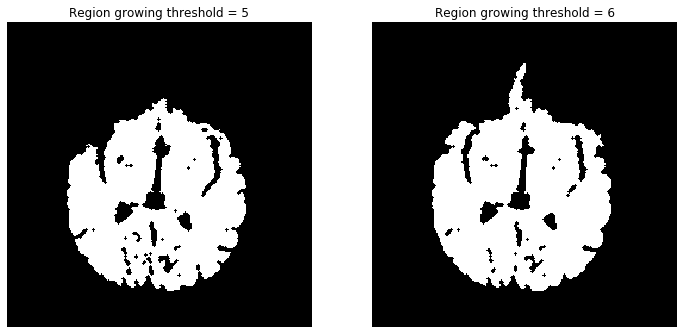

In [6]:
def region_grow_bounded(image, th1, th2):
    mask_t1 = np.zeros(image.shape)
    mask_t2 = np.zeros(image.shape)
    newimage_t1 = np.ones(image.shape) * 255
    newimage_t2 = np.ones(image.shape) * 255

    # generate the masks corresponding to the regions, with seed = (150, 150)
    for i,j in grow_region(image, 150,150, im_w,im_h, th1, {}):
        mask_t1[i][j] = 1
    for i,j in grow_region(image, 150,150, im_w,im_h, th2, {}):
        mask_t2[i][j] = 1

    mask_t1 = mask_t1 > 0
    mask_t2 = mask_t2 > 0

    # use math. morph. to close the masks, in order to remove some of the
    # noise due to the rigidity of fixed thresholding
    mask_t1 = ndi.binary_closing(mask_t1)
    mask_t2 = ndi.binary_closing(mask_t2)

    # vizualize the region generated
    newimage_t1[mask_t1] = image[mask_t1]
    newimage_t2[mask_t2] = image[mask_t2]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
    axes[0].imshow(mask_t1, cmap='gray')
    axes[0].set_title(f"Region growing threshold = {th1}")
    axes[0].axis('off')
    axes[1].imshow(mask_t2, cmap='gray')
    axes[1].set_title(f"Region growing threshold = {th2}")
    axes[1].axis('off')
    plt.show()
    
    return mask_t1, mask_t2
    
mask_t1, mask_t2 = region_grow_bounded(brain_im, 5, 6)

Neither result is ideal, but neither one is terrible either. By looking at them, it appears that it would be possible to estimate the brain size in pixels by taking their average, compensating for the left result's lack of the top left part of the brain, and  the right result's excess at the top. This would however, very likely be an underestimative, since both images overestimate the size of the holes in the brain matter.

Still, the one obtained for a threshold value of 5 seems to be the best of the two. We illustrate it in the next figure.

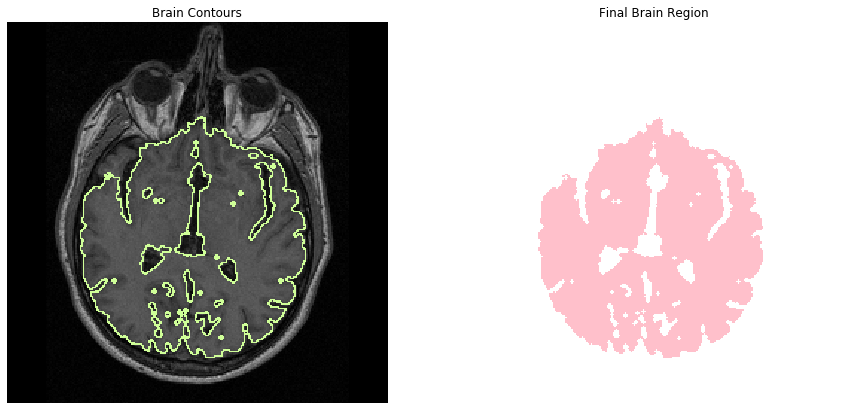

The brain region size in pixels: 15675
The brain region percent of total image: 23.92%


In [7]:
#Brain region with a threshold of 5
mm = np.ones((256,256), np.uint8)
mm[mask_t1==0] = 0
show_results(mm, "initial_region_growing")
_, _ = getNumberOfBrainPixels(mask_t1)

Contour detection and histogram equalization might prove helpful to get more accurate results. Let us investigate.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 1.3 Contour detection

#### Initial Contour Enhancement
Let's test some of the methods we learned in class for contour enhancement, such as taking gradients of the image, Laplacians, the Laplacian of the Gaussian, and various highpass filters.

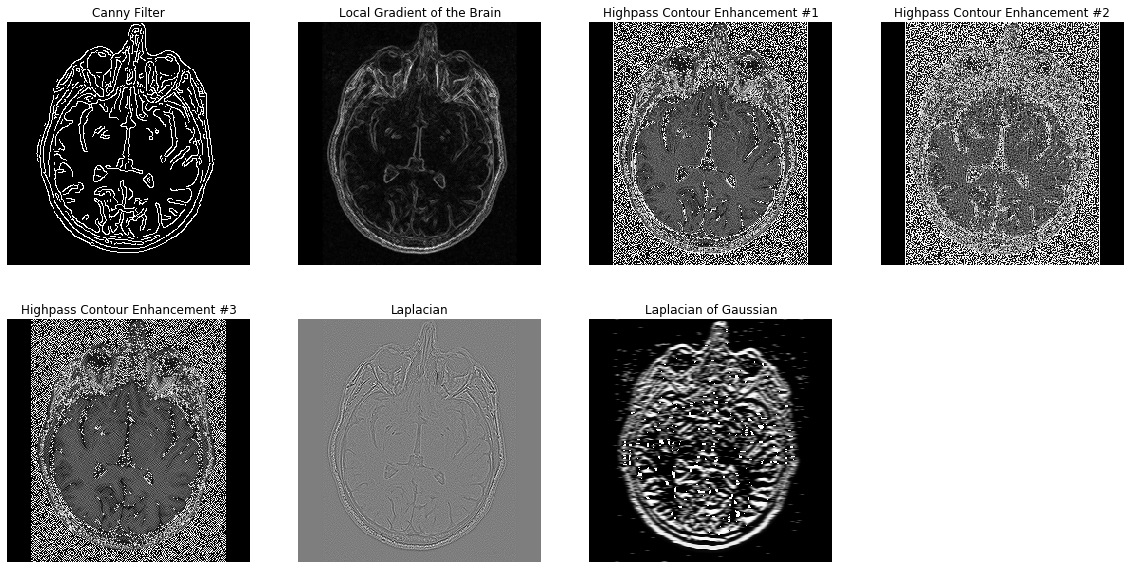

In [8]:
all_contour_detection(brain_im)

#### Problem: Image Quality
We can see that while some contour enhancement methods (Canny and Gradient) isolate the brain contours, these contours are either disjoint or not very sharp. Furthermore, any highpass filters amplify background noise. Therefore, our next step is to try filtering the image before performing contour enhancement, as well as using pixel thresholding to preserve only the brain pixels.

### 1.3.1 Thresholding
We first analyze the histogram of the image to see if we can approximate the pixel values of the brain and background using Gaussian curves.

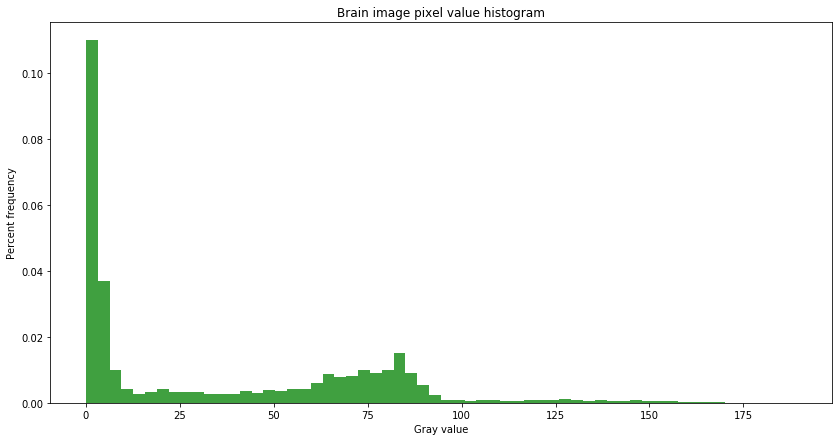

In [9]:
plt.figure(figsize=(14,7))
n, bins, patches = plt.hist(brain_im.ravel(),60, density=1, facecolor='green', alpha=0.75)
plt.title("Brain image pixel value histogram")
plt.xlabel("Gray value")
plt.ylabel("Percent frequency")
plt.show()

#### Initial Histogram Analysis
We can see from the histogram that the data follows a sort of intersection of Gaussian distributions: The low-pixel-value peak, in theory, corresponds to the black background pixels, whereas the more shallow Gaussian near the middle corresponds to the gray brain values. There are a few high-valued pixels, corresponding to the bright white skull.

#### Gaussian Fitting
Next, we fit this data to two Gaussians to estimate the mean and standard deviation of the background and brain pixel grayscale values.

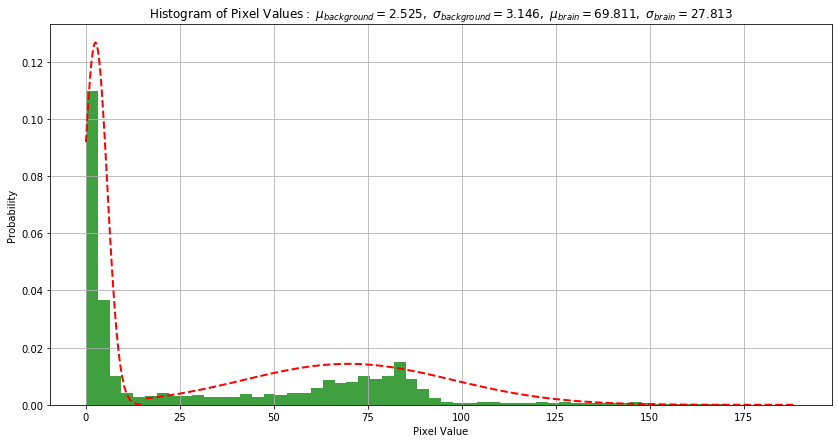

In [10]:
# get the best fit of the data
# separator between background and brain = minimum pixel frequency below 25
separator = bins[1:][np.argmin(n[bins[1:] < 25])]
datos = brain_im.ravel()
datos1 = datos[datos < separator] # background pixels
datos2 = datos[datos > separator] # brain and skull pixels
(mu1, sigma1) = norm.fit(datos1) #estimate the mean and st. dev. of background pixels
(mu2, sigma2) = norm.fit(datos2) #estimate the mean and st. dev. of brain pixels

# the histogram of the data
n2, bins2, patches = plt.hist(datos2, 60, density=1, facecolor='green', alpha=0.75)
n1, bins1, patches = plt.hist(datos1, 60, density=1, facecolor='green', alpha=0.75)
plt.close()
plt.figure(figsize=(14,7))
n, bins, patches = plt.hist(datos, 60, density=1, facecolor='green', alpha=0.75)

# add 'best fit' Gaussian curves to the background and brain pixels
y = norm.pdf( bins1, mu1, sigma1)
l = plt.plot(bins1, y, 'r--', linewidth=2)
y = norm.pdf( bins2, mu2, sigma2)
l = plt.plot(bins2, y, 'r--', linewidth=2)

#plot
plt.xlabel('Pixel Value')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Pixel\ Values:}\ \mu_{background}=%.3f,\ ' % (mu1) + \
          r'\sigma_{background}=%.3f, \ \mu_{brain}=%.3f,\ \sigma_{brain}=%.3f$' % (sigma1, mu2, sigma2))
plt.grid(True)
plt.show()

#### Brain isolation
Next, to isolate the brain from the higher pixel values, which correspond to the skull, we threshold the image based on pixel values within one brain standard deviation from the mean of the brain pixels.

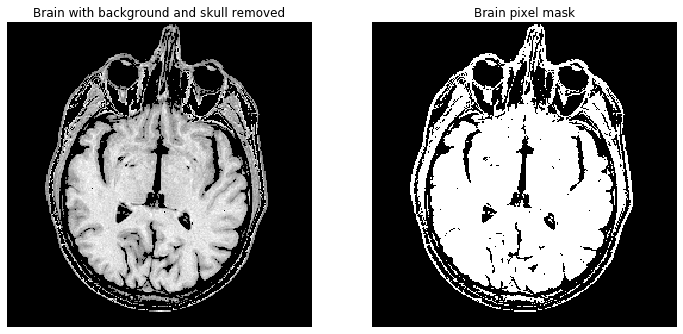

In [11]:
brain_with_zero_background, mask = get_thresholded_brain(brain_im,1)

# plot brains
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
axes[0].imshow(brain_with_zero_background, cmap='gray')
axes[0].set_title("Brain with background and skull removed")
axes[0].axis('off')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Brain pixel mask")
axes[1].axis('off')
plt.show()

One can observe that cerebrospinal fluid pixels are removed as well as the part of the skull pixels. However, most of the skull pixels are still present and this should become the object of further analysis.

From here we mark this image with `brainLR`, meaning brain-liquid removed. This is for purpose of better tractability of the following steps.

### 1.3.2 Filtering

Now let's see the effects of applying filters to both the original and `brainLR` image. We use the **median filter**, which is a lowpass filter, to reduce pixel variations within the brain and background regions while preserving the contours of the image. The **Wiener filter** similarly aims to remove the background noise while sharpening contours. The **Sobel** and **Scharr filters** are high-pass, and thus they enhance contours. **Histogram equalization** illuminates the brain region but skull as well, which is to be expected.

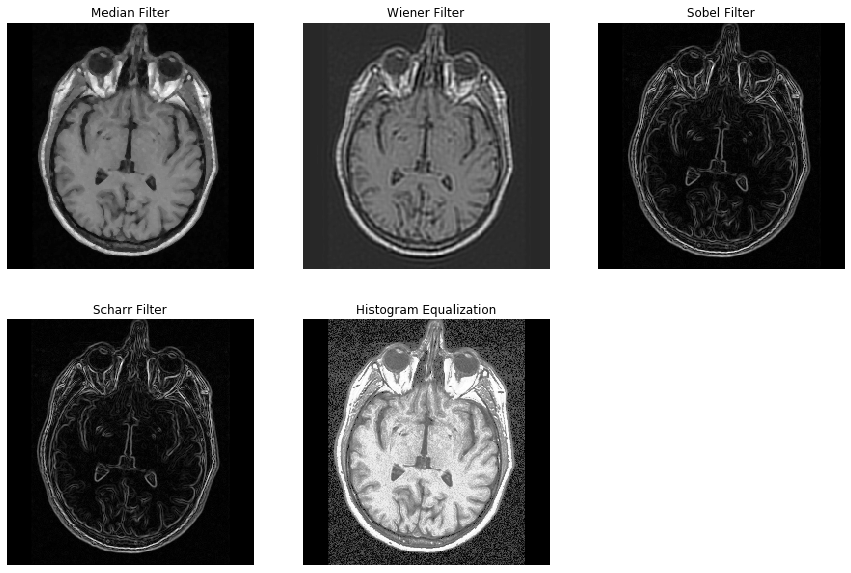

In [12]:
# test filters on the full image
test_all_filters(brain_im)

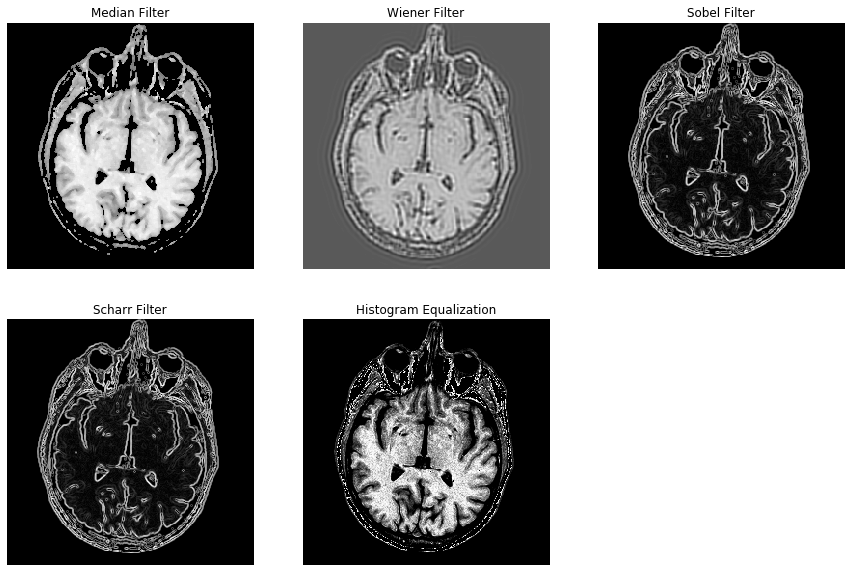

In [13]:
# test filters on the brainLR image
test_all_filters(brain_with_zero_background)

##### Result:
We can see that the median, Scharr, and Sobel filters highlight the contours of the brain image quite nicely. Furthermore, removing the background and liquid pixels through thresholding further amplifies the brain contours. Histogram equalization seems to have a good effect on differentiating gray and white matter of the brain.

### 1.3.3 Contour Enhancement
Let's try high-pass filtrering and contour detection on the `brainLR`, as well as contour detection following low-pass filtering.

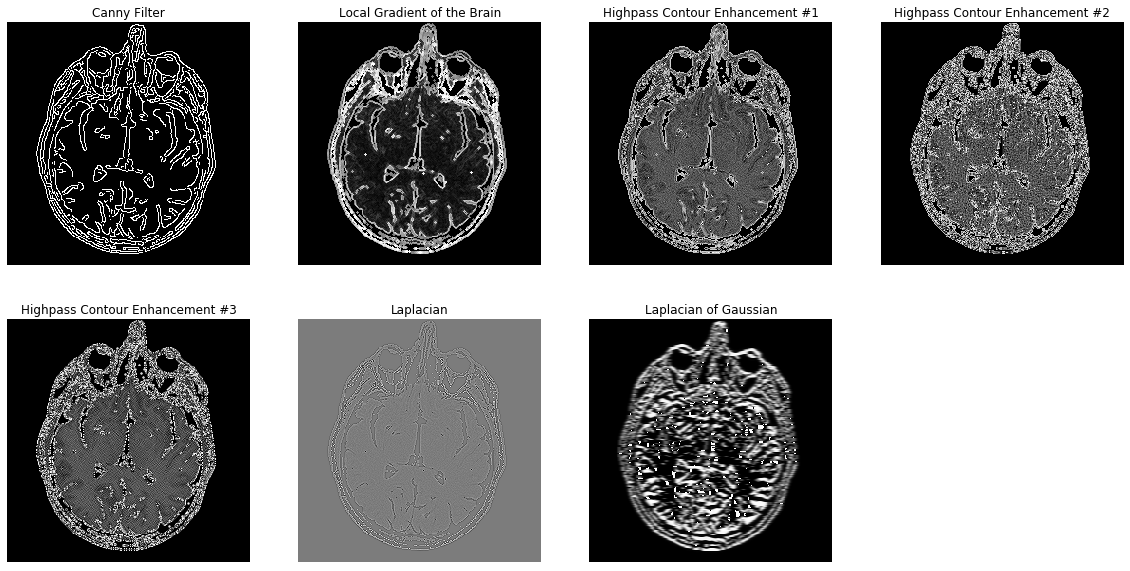

In [14]:
# contour detection on thresholded brain
all_contour_detection(brain_with_zero_background)

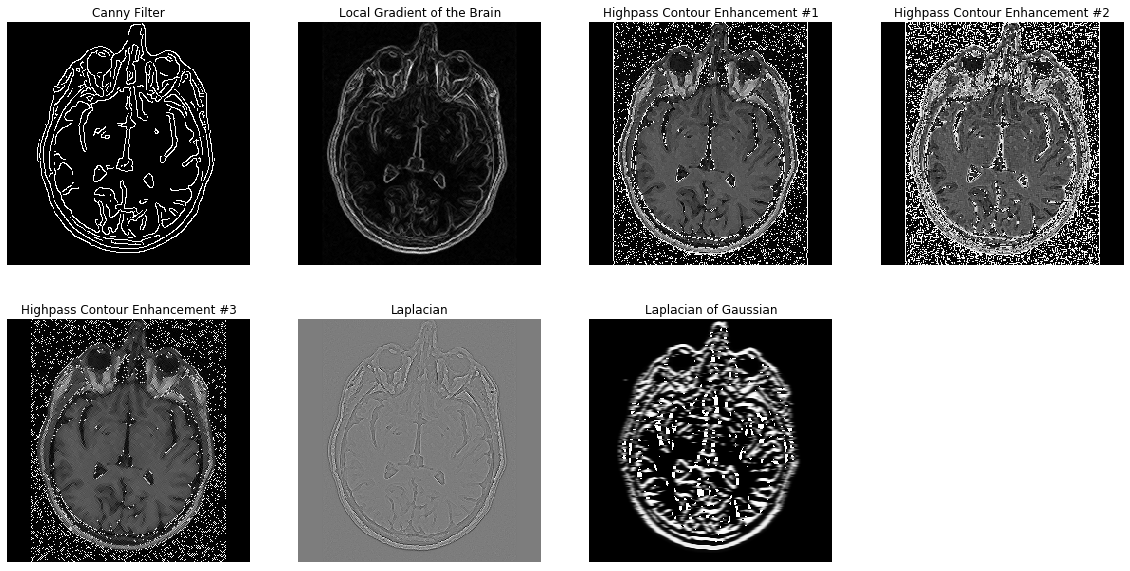

In [15]:
# contour detection on the median brain
all_contour_detection(filters.median(brain_im))

#### Most successful outcomes
Let's analyze the outcomes that most successfully highlighted the contours of the brain. These will later be combined with region growing to try to better isolate the brain within the contours.

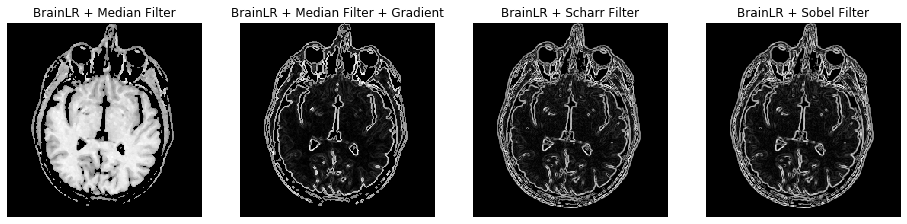

In [16]:
# thresholded image + median-filtered brain
median_im = filters.median(brain_with_zero_background)

# gradient on median filtered, thresholded brain image
grad_thresh = filters.rank.gradient_percentile(filters.median(brain_with_zero_background),
                                               disk(1), p0=50/255, p1=240/255)

# thresholded image + scharr filter
scharr_thresh = filters.scharr(brain_with_zero_background)

# sobel filter on the thresholded brain
sobel_brain = filters.sobel(brain_with_zero_background)

# plot filtered brains
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16), sharey=True)
axes[0].imshow(median_im, cmap='gray')
axes[0].set_title("BrainLR + Median Filter")# + Canny Edges")
axes[0].axis('off')
axes[1].imshow(grad_thresh, cmap='gray')
axes[1].set_title("BrainLR + Median Filter + Gradient")
axes[1].axis('off')
axes[2].imshow(scharr_thresh, cmap='gray')
axes[2].set_title("BrainLR + Scharr Filter")
axes[2].axis('off')
axes[3].imshow(sobel_brain, cmap='gray')
axes[3].set_title("BrainLR + Sobel Filter")
axes[3].axis('off')
plt.show()

### 1.3.4 Combining thresholding and region growing

We take these best-case filtered-and-contour-extracted images, threshold them to enhance their brightest contours and define clear cutoffs between the brain and its contours, and then apply region growing to identify the brain pixels. Since the Scharr and Sobel filter results seem to be highly similar, we chose to use solely the Sobel one.

The brain region size in pixels: 17136.0
The brain region percent of total image: 26.15%


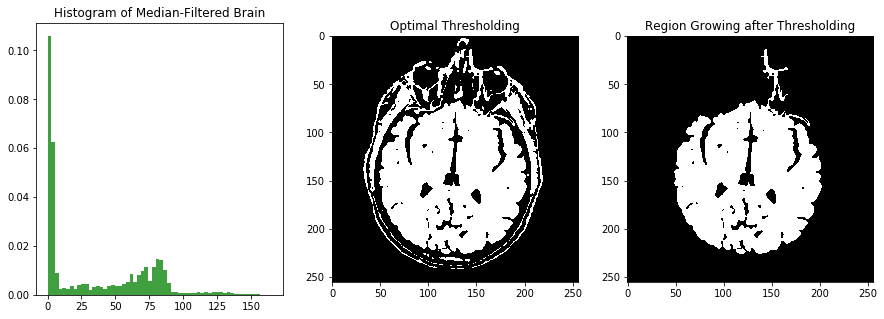

In [17]:
# optimal thresholding on the median-filtered image
med_brain = filters.median(brain_im)
brain_with_zero_background_med, mask_med = get_thresholded_brain(med_brain,0.85)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
n, bins, patches = axes[0].hist(med_brain.ravel(), 60, density=1, facecolor='green', alpha=0.75)
axes[0].set_title("Histogram of Median-Filtered Brain")
axes[1].imshow(mask_med, cmap='gray')
axes[1].set_title("Optimal Thresholding")

# region growing + contour detection on thresholded sobel brain
mask_median = np.zeros(mask_med.shape)
for i,j in grow_region(mask_med, 150,150, mask_med.shape[0],mask_med.shape[1], 1, {}):
    mask_median[i][j] = 1
axes[2].imshow(mask_median, cmap='gray')
axes[2].set_title("Region Growing after Thresholding")

getNumberOfBrainPixels(mask_median)
plt.show()

The brain region size in pixels: 15798.0
The brain region percent of total image: 24.11%


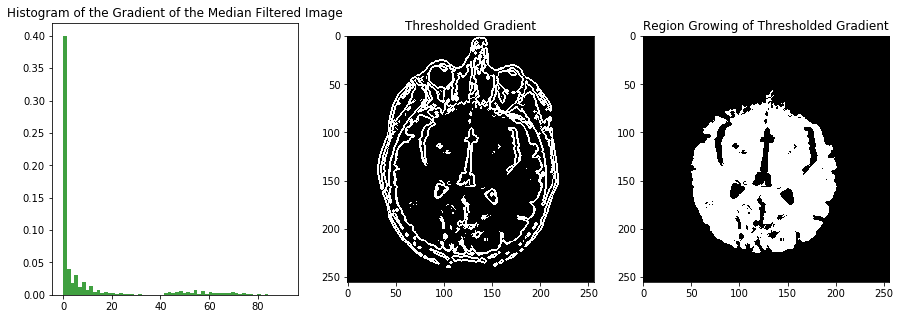

In [18]:
# apply thresholding to the gradient of the median filtered image
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
n, bins, patches = axes[0].hist(grad_thresh.ravel(), 60, density=1, facecolor='green', alpha=0.75)
axes[0].set_title("Histogram of the Gradient of the Median Filtered Image")

img = (grad_thresh > 20)
axes[1].imshow(img, cmap='gray')
axes[1].set_title("Thresholded Gradient")

# region growing + contour detection on thresholded gradient brain
mask_grad_th = np.zeros(img.shape)
for i,j in grow_region(img, 150,150, img.shape[0],img.shape[1], 1, {}):
    mask_grad_th[i][j] = 1
axes[2].imshow(mask_grad_th, cmap='gray')
axes[2].set_title("Region Growing of Thresholded Gradient")

getNumberOfBrainPixels(mask_grad_th)
plt.show()

The brain region size in pixels: 14002
The brain region percent of total image: 21.37%


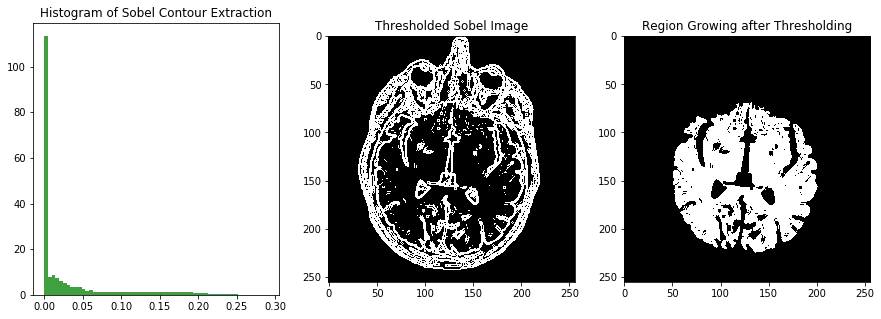

In [19]:
# apply thresholding to the sobel filtering contour extraction above
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
n, bins, patches = axes[0].hist(sobel_brain.ravel(), 60, density=1, facecolor='green', alpha=0.75)
axes[0].set_title("Histogram of Sobel Contour Extraction")

img = (sobel_brain > 0.05)
axes[1].imshow(img, cmap='gray')
axes[1].set_title("Thresholded Sobel Image")

# region growing + contour detection on thresholded sobel brain
mask_sobel_th = np.zeros(img.shape)
for i,j in grow_region(img, 150,150, img.shape[0],img.shape[1], 1, {}):
    mask_sobel_th[i][j] = 1
mask_sobel_th = mask_sobel_th > 0
axes[2].imshow(mask_sobel_th, cmap='gray')
axes[2].set_title("Region Growing after Thresholding")

getNumberOfBrainPixels(mask_sobel_th)
plt.show()

##### Result:
Thresholding of the median filtering results preserves the contours, but the rest of the head is still attached to the brain. Then the region growing captures some of the head pixels as well, thereby overestimating the brain region. 
This could be solved if we change the threshold value, but then a new challenge arises. Namely, there is a trade-off between removing the skull and keeping as many brain pixels as possible. So, if we change the threshold and remove the entire skull, we loose part of brain pixels. This motivated us to perform mathematical morphology operations, such as image opening and erosion. In other words, a good option is to fist threshold the image such that all brain pixels are kept, afterwards get rid of connection with skull pixels (thorugh morphological operations), and finally, perform region growing.

Thresholding the Sobel and gradient contours provide promising brain regions (especially the latter one), although they include several small holes in the brain. More precisely, `brainLR` followed by median filter, gradient, thresholding and region growing gives the best result so far. We represent this outcome in the next figure. 

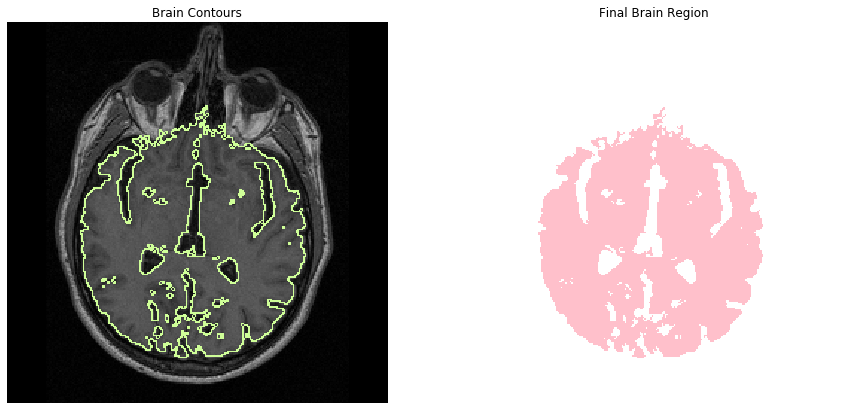

The brain region size in pixels: 15798.0
The brain region percent of total image: 24.11%


In [20]:
# final brain visualization using the thresholded gradient image above
mm = np.ones((256,256),np.uint8)
mm[mask_grad_th==0] = 0
show_results(mm, "region_growing_threshold_gradient")
_, _ = getNumberOfBrainPixels(mask_grad_th)

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 1.4 Additional method(s)

### 1.4.1 Merging thresholding and mathematical morphology

The segmented brain masks that we made by combining contour detection and thresholding in the previous section were promising. However, sometimes the rest of the head was still attached to the brain by a few pixels, leading to an overestimated brain region. On the other hand, sometimes there were holes in the brain due to overly high thresholds that left gaps in the middle of the brain during region growing. 

These problems can be overcome using mathematical morphology operations, which can fill the holes in images and erode away the links between the brain and skull.

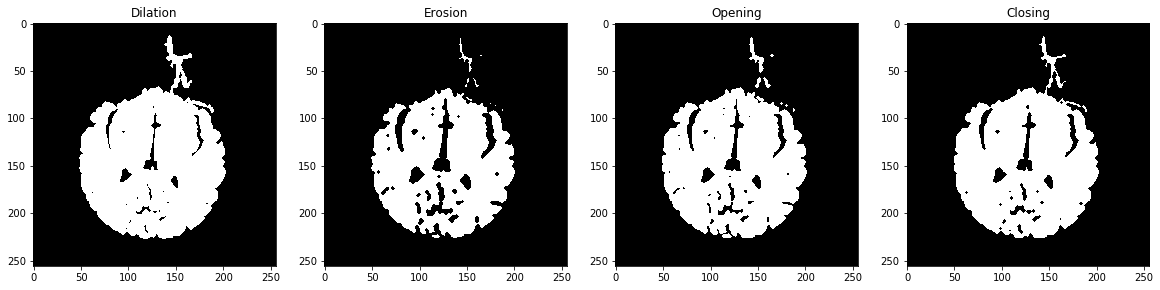

In [21]:
# visualize mathematical morphology operators on median mask
visualizeMathematicalMorphology(mask_median)

#region growing + mathematical morphology on the median-filtered brain
#brain_with_zero_background, mask = get_thresholded_brain(med_brain, 0.85)
#visualizeMathematicalMorphology(mask)

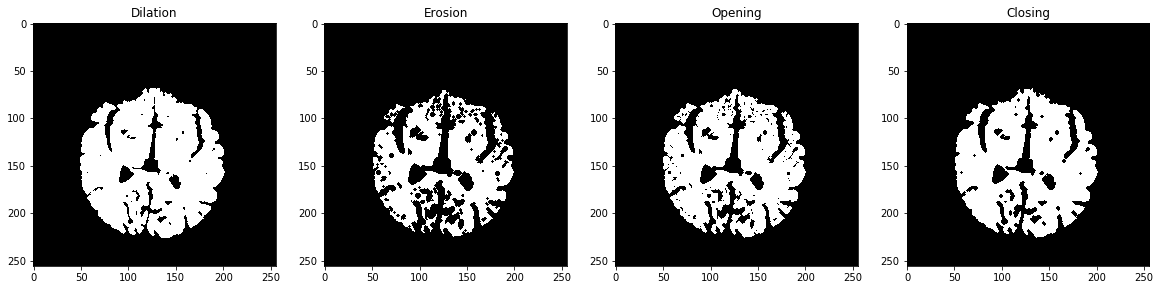

In [22]:
# visualize mathematical morphology operators on sobel mask
visualizeMathematicalMorphology(mask_sobel_th)

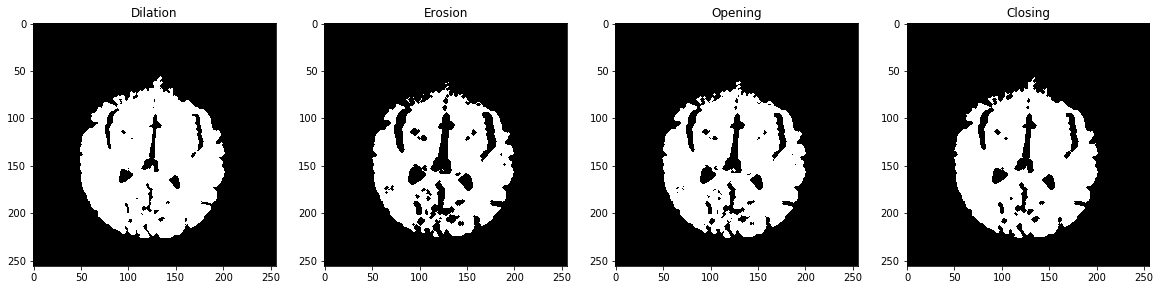

In [23]:
# visualize mathematical morphology operators on gradient mask
visualizeMathematicalMorphology(mask_grad_th)

##### Result:

As expected, dilation closes the holes, which has a positive impact on the Sobel mask obtained in the previous section (result is shown in first figure below). It also increases the brain size and in first case (median-filtered image mask), and emphasizes the connection between the brain and the skull.

Erosion successfully detaches the brain from the rest of the head for the median-filtered brain, but it augments the holes and produces missing brain pixels, especially in the case of the Sobel and gradient images.

Opening is an optimal operation for the median-filtered image because it opens the connection of skull to the brain pixels, while keeping the brain scope and allowing us to run region growing to isolate the brain.

Closing just closes the holes, which is not desirable, because the original image has some discontinuities caused by gyri and sulci.

Let us now apply region growing to isolate the brain pixels from the opened median-filtered image. In the second figure below, we can see that this produces a fairly good representation of the brain with accurate contours and few extraneous holes or contours.

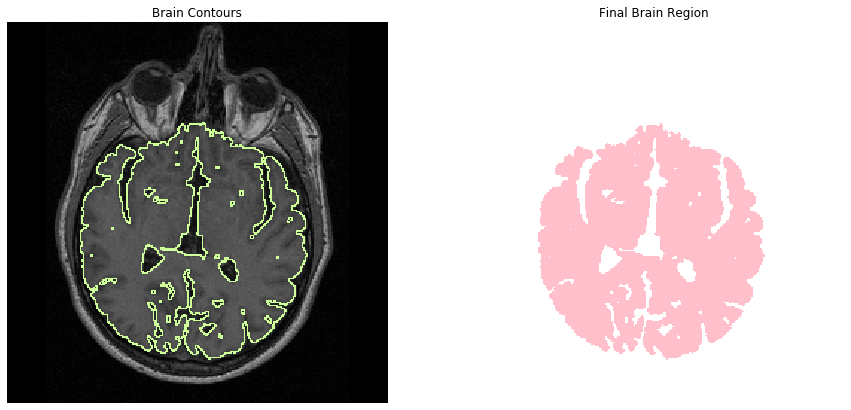

The brain region size in pixels: 16142
The brain region percent of total image: 24.63%


In [24]:
# best results: Dilating Sobel mask
dil_sobel_mask = ndi.binary_dilation(mask_sobel_th)
mm = np.ones((256,256), np.uint8)
mm[dil_sobel_mask==0] = 0
show_results(mm, "thresholding_sobel_region_growing_dilation")
_, _ = getNumberOfBrainPixels(dil_sobel_mask)

The brain region size in pixels: 16727.0
The brain region percent of total image: 25.52%


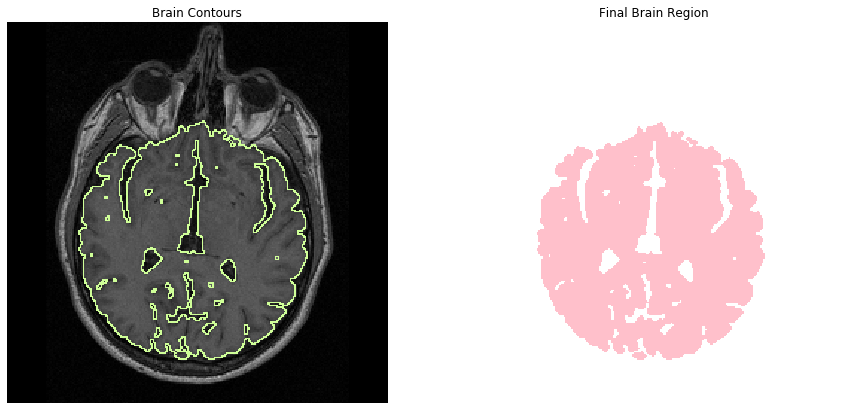

In [25]:
# best results: region growing in the opened median-image mask
img = ndi.binary_opening(mask_median)
mask_th = np.zeros(img.shape)
for i,j in grow_region(img, 150,150, im_w,im_h, 1, {}):
    mask_th[i][j] = 1
_, _ = getNumberOfBrainPixels(mask_th)

mm = np.ones((256,256), np.uint8)
mm[mask_th==0] = 0
show_results(mm,"thresholding_opening_region_growing")

### 1.4.2 An overview of other python-segmentation methods 

##### Watershed segmentation

We first apply a Sobel filter to the brain image to extract the contours, and then apply watershed segmentation to label different regions of the brain. After this, we apply a hole-filling operation to fill the holes in the segmented brain mask. 

This technique manages to distinguish the brain region from its surroundings, but fails to include a significant portion of the posterior left hemisphere.

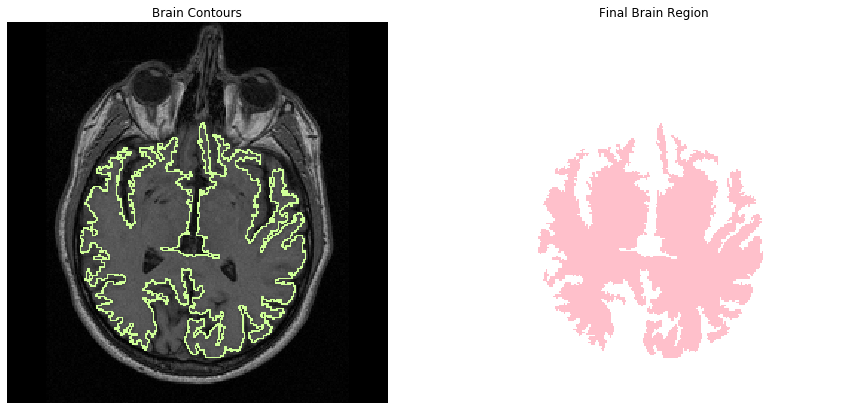

In [26]:
# define markers and thersholds
markers = np.zeros_like(brain_im)
SEP_VAL = 70
markers[brain_im < SEP_VAL] = 1
markers[brain_im > SEP_VAL] = 2

# segment
elevation_map = sobel(brain_im)
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)

# extract brain segment and plot result
labeled_segments, _ = ndi.label(segmentation)
indices = np.indices(brain_im.shape).T[:,:,[1, 0]]
ws_mask = np.zeros(brain_im.shape)
for j,k in indices[(labeled_segments == 95).T]:
    ws_mask[k][j] = 255
mm = np.ones((256,256), np.uint8)
mm[ws_mask==0] = 0
show_results(mm, "watershed")

##### Otsu thresholding
We apply OTSU thresholding to the image to extract the brain. Then, we perform closing to fill the holes in the segmented brain, and then remove artifacts at the image border. This method does not successfully separate the brain from the rest of the skull.

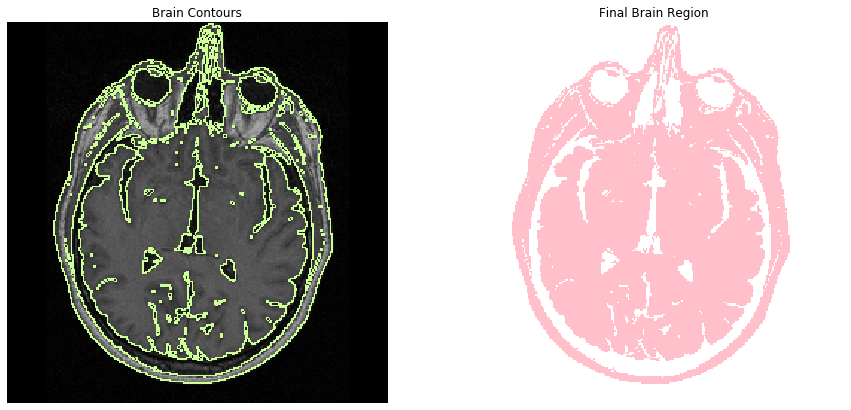

In [27]:
# apply threshold
thresh = threshold_otsu(brain_im)
bw = closing(brain_im > thresh, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions and plot result
label_image = label(cleared)
indices = np.indices(brain_im.shape).T[:,:,[1, 0]]
ws_mask = np.zeros(brain_im.shape)
for j,k in indices[(label_image == 1).T]:
    ws_mask[k][j] = 255
mm = np.ones((256,256), np.uint8)
mm[ws_mask==0] = 0
show_results(mm, "otsu")

##### Chan_vese segmentation
We apply Chan-Vese segmentation, which is also incapable of separating the brain pixels from skull ones.

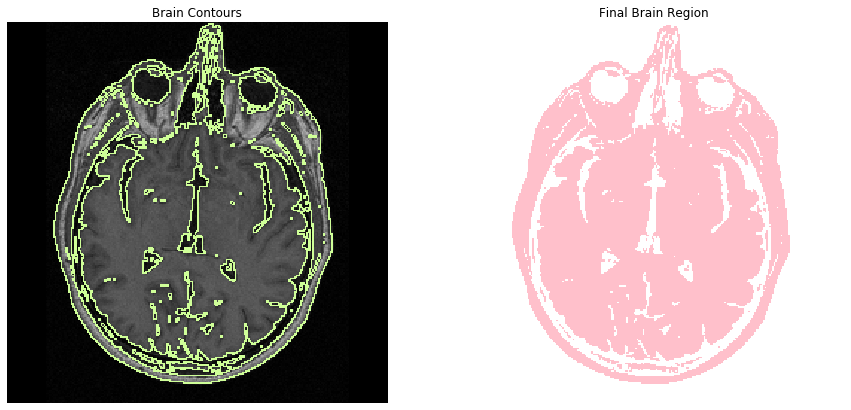

In [28]:
chan_brain = chan_vese(brain_im, mu=.005)
mm = np.ones((256,256), np.uint8)
mm[chan_brain==0] = 0
show_results(mm, "chanvese")

##### Smoothed watershed
We apply a median filter to the image before performing contour extraction via a gradient operator. Then, watershed segmentation is used to label the brain segments. This method segments the entire head, not only the brain, and the brain ends up being composed of parts of different segments, which is clearly not the desired reult.

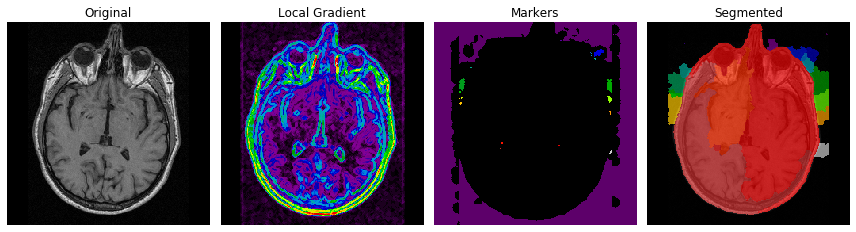

In [29]:
image = brain_im.copy()

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient - where less than 10 for this image)
# disk(5) is used here to get a smoother image
markers = rank.gradient(denoised, disk(6)) < 5
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### 1.4.3 Final brain segmentation
For our final brain segmentation attempt, we combine a few of most relevant methods shown above, and we use an OpenCV function for finding contours (`cv2.findContours`). The steps are as follows:

1. We start from the previously-extracted optimally-thresholded brain pixels using our custom-built function - `brainLR`. As previously stated, the brain is separated from the cerebrospinal liquids but there are still bone pixels left.
2. We apply the OpenCV thresholding method to make a binary mask out of this image.
3. Image opening is used to roughly separate the brain pixels from those of the surrounding bones. There are still some pixels left, but we will handle them in the next steps.
4. OpenCV's contour-finding function is used to find all of the contours.
5. The brain's contour is the third one and we select it. Now we have only brain pixels, but since we performed opening in step 3, there is the possibility that we lost pixels in the neighborhood of the edges. That's why we interpret this as a mask (`cv2.drawContours` with `thickness=cv2.FILLED`) and dilate it.
6. The mask obtained in steps 3, 4, and 5 assures us of a full brain contour, without bones but with liquids. However, the mask obtained from steps 1 and 2 removes the cerebrospinal liquids. Hence, if we combine them we obtain only the brain pixels. The result is shown in the figure below.

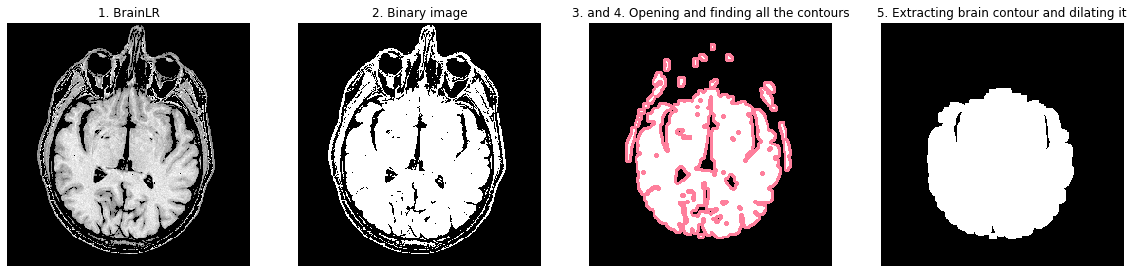

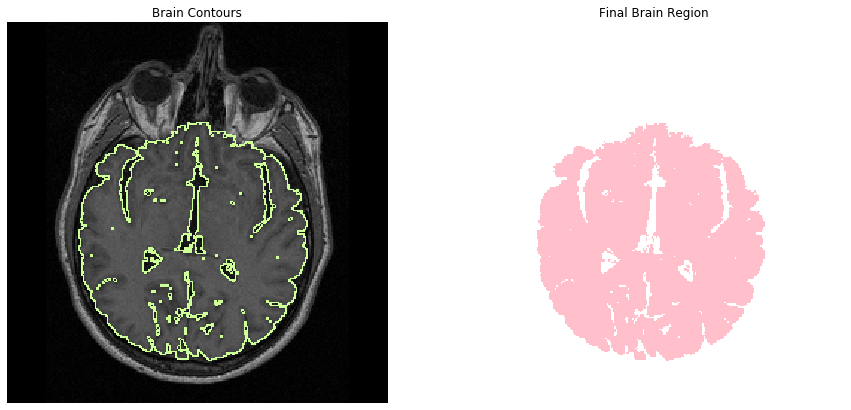

The brain region size in pixels: 17305
The brain region percent of total image: 26.41%


In [30]:
# brain_with_zero_background is not a binary image, so we make it binary and 
# then we perform opening in order to roughly remove the skull and to enable
# the function findContours to find the brain contour, and not the bones
brain_with_zero_background, mask = get_thresholded_brain(brain_im, 1)
kernel = np.ones((5,5), np.uint8)
ret, thresh2 = cv2.threshold(brain_with_zero_background, 40, 255, cv2.THRESH_BINARY)
opening = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel)

#function findContours finds the brain contour
original_copy2 = brain_im.copy()

ni, contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# create mask based on the found contour, then dilate it, because due to the previous
# opening maybe the peripheral structure of  the brain is not under the mask
m1 = np.zeros((256,256), np.uint8)
mask = cv2.drawContours(m1, contours, 3, (255,255,255), thickness=cv2.FILLED)

contours_found = opening.copy()
contours_found = cv2.cvtColor(contours_found, cv2.COLOR_GRAY2RGB)
contours_found = cv2.drawContours(contours_found, contours, -1, (254,127,156), 2)

kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask, kernel, iterations=1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20), sharey=True)
axes[0].imshow(brain_with_zero_background, cmap='gray')
axes[0].set_title("1. BrainLR")
axes[0].axis('off')
axes[1].imshow(thresh2, cmap='gray')
axes[1].set_title("2. Binary image")
axes[1].axis('off')
axes[2].imshow(contours_found, cmap='gray')
axes[2].set_title("3. and 4. Opening and finding all the contours")
axes[2].axis('off')
axes[3].imshow(mask_dilated, cmap='gray')
axes[3].set_title("5. Extracting brain contour and dilating it")
axes[3].axis('off')
plt.show()

# we first use thresh2 as a mask for background, because, when we aply dilated mask,
# we want to be sure that we don't extract skull layers
original_copy2[thresh2==0] = 0
original_copy2[mask_dilated==0] = 0

mm = np.ones((256,256), np.uint8)
mm[original_copy2==0] = 0
show_results(mm, "opencv_brain")
_, _ = getNumberOfBrainPixels(original_copy2 > 0)
plt.show()

##### Result:
This brain segmentation using OpenCV functions and mathematical morphology produces a seemingly accurate contour around the brain, which is slightly less smooth than the result in Section 1.4.1, but the holes inside the brain tissue are smaller and it looks more symmetric than in previous implementations.

<hr style="margin-bottom:40px">
<div style="background:#CCC; height:200%;"><h2 style="width: 100%; text-align: center; border-bottom: 1px solid #000; line-height: 0.1em; margin: 10px 0 20px;"><span style="background:#fff; padding:0 10px; border-radius: 8px;">As such, our final brain size estimate (in pixels) is 17305.</span></h2></div>
<hr style="margin-top:30px">

### 1.4.4 Overview of Successful Brain Segmentations

*Note: if the images are not displaying, please run all cells above and then the one below.*

<table align='left'>

  <tr>
    <th width='50' align='center'>Description</th>
    <th width='150' align='center'>Initial Region Growing</th>
    <th width='150' align='center'>BrainRL + Gradient + Region Growing</th>
    <th width='150' align='center'>BrainRL + Sobel Filter + Region Growing + Dilation</th>
    <th width='150' align='center'>BrainRL + Median filtering + Opening + Region Growing </th>
    <th width='150' align='center'>BrainRL mask + Opening + Contour Finding + Dilation mask + Combining two masks</th>
  </tr>
  <tr>
      <td>Image</td>
      <td><img src='initial_region_growing.jpg' width='150' height='200'/></td>
      <td><img src='region_growing_threshold_gradient.jpg' width='150' height='200'/></td>
      <td><img src='thresholding_sobel_region_growing_dilation.jpg' width='150' height='200'/></td>
      <td><img src='thresholding_opening_region_growing.jpg' width='150' height='200'/></td>
      <td><img src='opencv_brain.jpg' width='150' height='200'/></td>
  </tr>
  <tr>
      <td>Pixel Count</td>
      <td width='150'>15675</td>
      <td width='150'>15798</td>
      <td width='150'>16142</td>
      <td width='150'>17099</td>
      <td width='150'>17305</td>
  </tr>
  <tr>
      <td>Percent of Brain Region</td>
      <td width='150'>23.92%</td>
      <td width='150'>24.11%</td>
      <td width='150'>24.63%</td>
      <td width='150'>26.09%</td>
      <td width='150'>26.41%</td>
  </tr>
</table>

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 1.4.5 Gray vs White Matter Segmentation

Now that we have successfully segmented the brain through a variety of methods, we can take it a step further and segment the gray and white matter of the brain. We achieve this by performing histogram equalization on the final brain image obtained (via segmenting using the combination of two masks, described in 1.4.3.). Histogram equalization highlights the differences between white and gray matter. 

We then threshold the image once again and take into account that white and gray pixels need to be in close proximity to each other, i.e. we also take the space relations into account. We do it by exploring the 5x5 window around each pixel. If more than eight pixels in window belong to white matter, the center is assumed to be white matter as well, and if otherwise, then it is assumed to belong to gray matter. The results are quite promising!

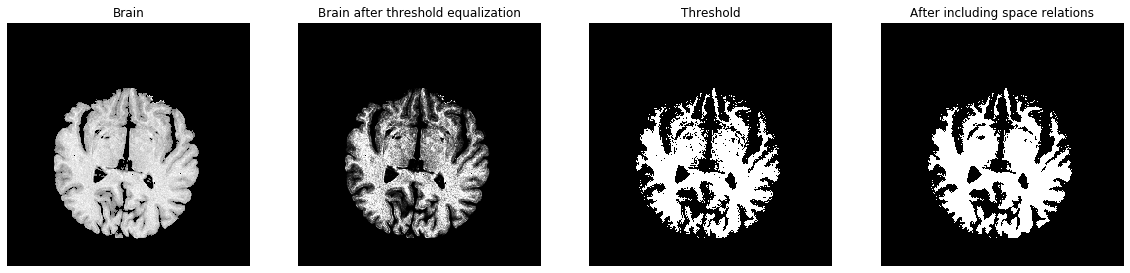

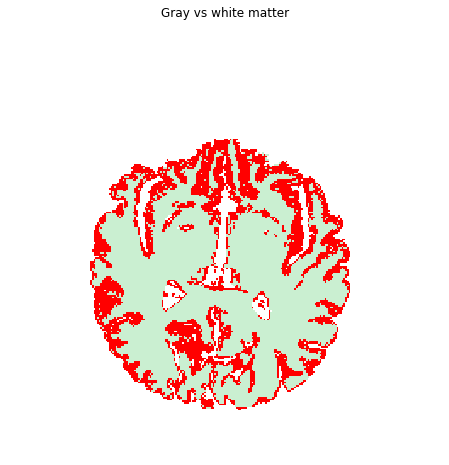

In [31]:
equalized = skimage.exposure.equalize_hist(original_copy2)
ret, thresh1 = cv2.threshold(equalized, 0.84, 1, cv2.THRESH_BINARY)

result = thresh1.copy()
for i in range(2,255):
    for j in range (2,255):
        c = sum( thresh1[i-2:i+2, j-2:j+2].flatten() )
        if c > 8:
            result[i,j] = 1


i1 = np.where(result == max(result.flatten()))
i2 = np.where(mm == 1)
i2 = (mm == 1)
i3 = (result == min(result.flatten()))
ind2 = np.where(i2 & i3)

mgw = 255 * np.ones((256,256,3), np.uint8)
mgw[i1[0], i1[1],0] = 202
mgw[i1[0], i1[1],1] = 239
mgw[i1[0], i1[1],2] = 209
mgw[ind2[0], ind2[1],0] = 255
mgw[ind2[0], ind2[1],1] = 0
mgw[ind2[0], ind2[1],2] = 0

# plot the results
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20), sharey=True)
axes[0].imshow(original_copy2, cmap='gray')
axes[0].set_title("Brain")
axes[0].axis('off')
axes[1].imshow(equalized, cmap='gray')
axes[1].set_title("Brain after threshold equalization")
axes[1].axis('off')
axes[2].imshow(thresh1, cmap='gray')
axes[2].set_title("Threshold")
axes[2].axis('off')
axes[3].imshow(result, cmap='gray')
axes[3].set_title("After including space relations")
axes[3].axis('off')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(mgw)
plt.title("Gray vs white matter")
plt.axis('off')
plt.show()

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## Appendix

### Wiener filter

The input image was alreay clean, so there was no need to pre-process it to remove any damage or deterioration. Applying a Wiener filter confirms this. 

skimage's Wiener filter method, `wiener`, takes `balance` as a parameter, the regularisation parameter that balances the data adequacy to improve frequency restoration and the prior adequacy to reduce frequency restoration. 

We present below one of the best output images from the application of the Wiener filter to the original image (resulting from a balance value of `0.05`). Higher values for this parameter quickly start to blur the image (the wiener filter begins acting like a low-pass filter), and lower values start generating noise, via the ringing effect (the wiener filter begins acting like a high-pass filter).

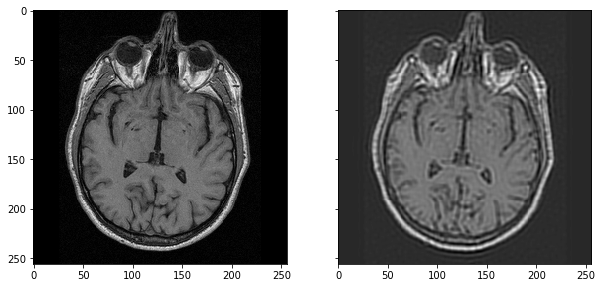

In [32]:
import numpy as np
from skimage import color, data, restoration

psf = np.ones((5, 5)) / 25
deconvolved = restoration.wiener(brain_im, psf, 0.05, clip=False)

# compare original and filtered
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), sharey=True)
axes[0].imshow(brain_im, cmap='gray')
axes[1].imshow(deconvolved, cmap='gray')
plt.show()

Despite the loss in quality, since the filter, in this case, acts as more of a low pass filter than a high pass well, slightly blurring the image, the region growing generates bigger regions, comparatively to the results produced by original image.

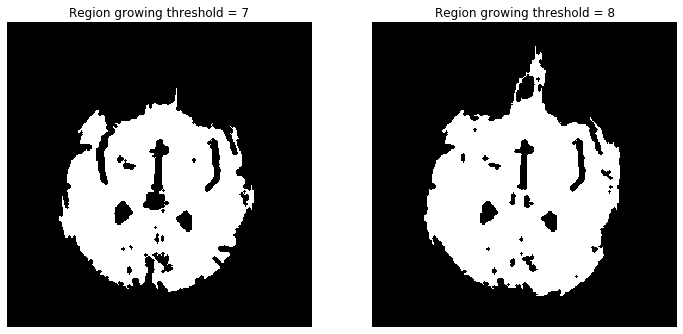

In [33]:
_ = region_grow_bounded(deconvolved, 7, 8)

### Growing all regions

Instead of expanding a single region from a set of seed coordinates, we can also obtain all the image's regions via a grid-based approach to region/seed finding. 

*Warning: This cell takes a bit of time to execute.*

In [34]:
run_this_cell = False

if run_this_cell:
    regions = []

    THRESHOLD = 10

    # segment the image
    for p_x in range(im_w):
        for p_y in range(im_h):
            # if already part of a region, do nothing
            if part_of_region(regions, p_x, p_y) < 0:
                # else, build region
                regions.append({'label': len(regions), 'pixels': grow_region(brain_im, p_x, p_y, 
                                                                         im_w,im_h, THRESHOLD, regions)})
                print(f"current nb of regions: {len(regions)}")

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## Part 2: Shape/color segmentation

In this exercise, we are looking for the number of shapes of each color and their corresponding total area in pixels. We have 3 RGB (red-green-blue) images at our disposal and the following challenge: images represent the same objective but they are taken under different lighting conditions. Because of this, good practice would be to perform image normalization and convert them to a single color intensity representation. We overcome this by applying histogram matching, where histograms of the entire set of images and all 3 channels are equalized and thus the resulting images have the same properties.

We apply methods such as region growing, contour detection, thresholding, K-means clustering, as well as combinations of them in order to obtain better performance. Additionaly, in some of the parts we convert images to the HSV (hue-saturation-value) domain. Especialy for methods that rely on color features, HSV offer us more flexibility in choosing parameters, because while in RGB channels different colors sometimes have similar intensities, that is not the case with HSV channels.

Here we illustrate our final results:

<br/>

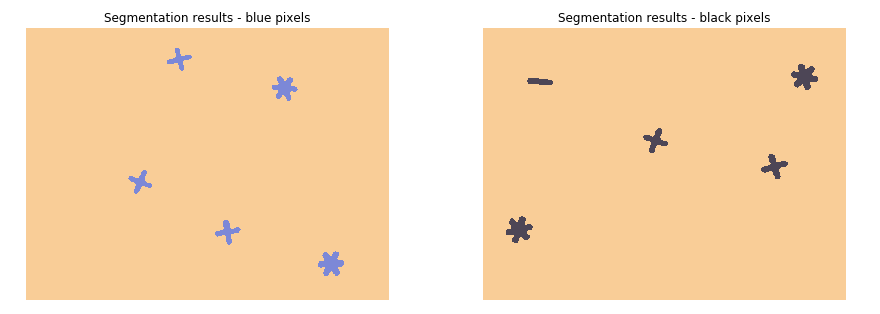

<br/><hr/>


### 2.1 Visualization

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


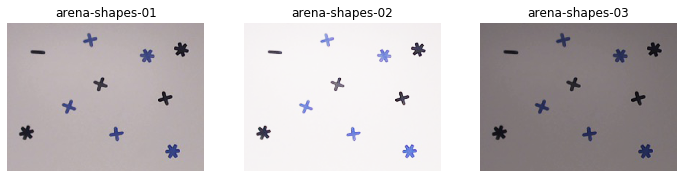

In [35]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

#### Helper functions
First, we define some helpful functions for manipulating and vizualizing images.

In [36]:
def show_results2(mask,names):
    """Function will plot result of one algorithm or make a subplot of 2, depending on number of input parameters.
    Mask can contain 2 or 4 masks. If you want to show results of only one algorithm then you have only 2 masks: 
    first one for blue pixels and second for black.
    Otherwise you compare 2 methods and you construct 4 masks in the following order: blue,black,blue,blck.
    Names include name/names of algorithm.
    Mask must be in form 1-where you detected the object, or 0-background. 
    Examples of calling:
    show_results([mask1, mask2],['kmeans'])

    result[result==255]=1
    result_black[result_black==255]=1
    show_results([mask1,mask2,result, result_black],['thresholding','kmeans'])"""

    result1 = construct_result([mask[0],mask[1]])
    
    if np.shape(mask)[0] == 4:
        result2 = construct_result([mask[2], mask[3]])
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].imshow(result1)
        axs[0].set_title('Segmentation results - '+names[0])
        axs[0].axis('off')
        axs[1].imshow(result2)
        axs[1].set_title('Segmentation results - '+names[1])
        axs[1].axis('off')
        
    else:
        plt.figure(figsize=(15,5))
        plt.imshow(result1)
        plt.title('Segmentation results - '+names[0])
        plt.axis('off')
        plt.show()

    

def construct_result(mask):
    """mask[0]-for blue pixels, mask[1]-for black pixels"""
    img = np.ones(np.shape(mask[0]), np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img[:, :, 0] = 249
    img[:, :, 1] = 205
    img[:, :, 2] = 151
    
    img[mask[0]==1, 0] = 124
    img[mask[0]==1, 1] = 136
    img[mask[0]==1, 2] = 215
    
    img[mask[1]==1, 0] = 77
    img[mask[1]==1, 1] = 70
    img[mask[1]==1, 2] = 86
    
    return img

def show_res_2fig(mask):
    #mask[0]-blue, mask[1]-black
    img = np.ones(np.shape(mask[0]), np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img[:, :, 0] = 249
    img[:, :, 1] = 205
    img[:, :, 2] = 151
    
    img_blue=img.copy()
    img_black=img.copy()
    img_blue[mask[0]==1, 0] = 124
    img_blue[mask[0]==1, 1] = 136
    img_blue[mask[0]==1, 2] = 215
    
    img_black[mask[1]==1, 0] = 77
    img_black[mask[1]==1, 1] = 70
    img_black[mask[1]==1, 2] = 86

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_blue)
    axs[0].set_title('Segmentation results - blue pixels')
    axs[0].axis('off')
    axs[1].imshow(img_black)
    axs[1].set_title('Segmentation results - black pixels')
    axs[1].axis('off')
    plt.show()


def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image.
    Code adapted from
    http://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def kmeas_clustering(image):
    "Perform k-means clustering with 10 clusters"
    # k-means' k
    k = 3 
    pixel_values = image.reshape((-1, 3))
    
    # convert to float
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.02)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)

    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    labels = labels.reshape(480,640)
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

### 2.1.1 Region Growing

First, we convert the image into its hue-saturation-value equivalent and use the latter, which represents the lightness of the color, to perform region growing. We use region growing to grow the background of the image, which we can then use to focus only on the shapes themselves.

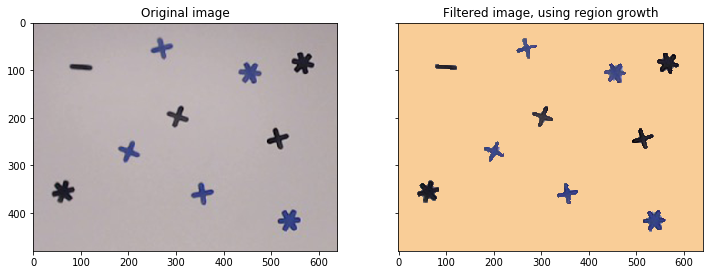

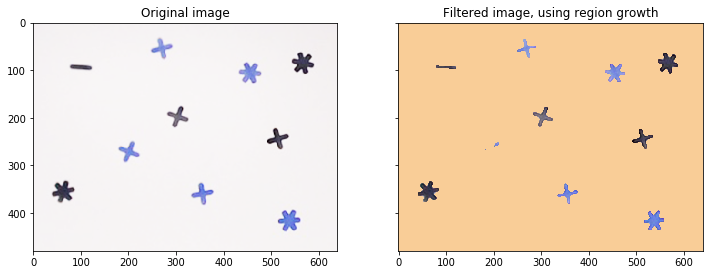

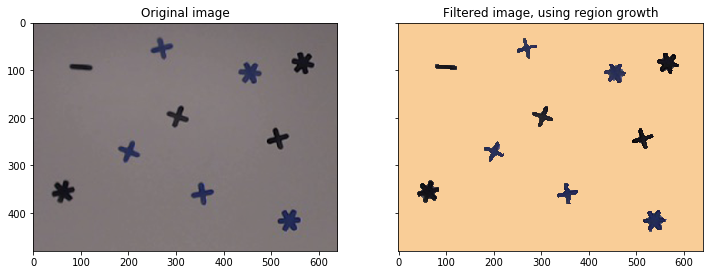

In [37]:
from skimage import color
from skimage.color import rgb2hsv
for i in range(len(images)):
    img = images[i]
    regions = []

    img_hsv = rgb2hsv(img)
    val_img = img_hsv[:, :, 2]
    im = val_img * 255

    THRESHOLD = 3

    # segment the image
    wid, hei = im.shape
    for p_x, p_y in ((w, h) for w in range(img.shape[0]) for h in range(img.shape[1])):
        # if already part of a region, do nothing
        if part_of_region(regions, p_x, p_y) < 0:
            # else, build region
            regions.append({'label': len(regions), 'pixels': grow_region(im, p_x, p_y, 
                                                                         wid,hei, THRESHOLD, regions)})
            break # isolates background

    mask = np.zeros(im.shape)
    newimage = img.copy()

    # generate the masks corresponding to the background region
    for j,k in regions[0]['pixels']:
        mask[j][k] = 1
    mask = mask > 0

    # trim white border around objects
    mask = ndi.binary_dilation(mask, iterations=3)

    # vizualize the resulting shapes
    newimage[mask] = [249, 205, 151]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newimage, cmap='gray')
    axes[1].set_title('Filtered image, using region growth')
    plt.show()

In most cases, all ten objects are detected, although some are quite small and faint like the (-) in the upper left corner. 

Next, we use region growing to separate one color from the other, by segmenting all shapes and then computing their average color values, and grouping values whose difference lies below a given threshold. We use the first image as a prototype for this segmentation.

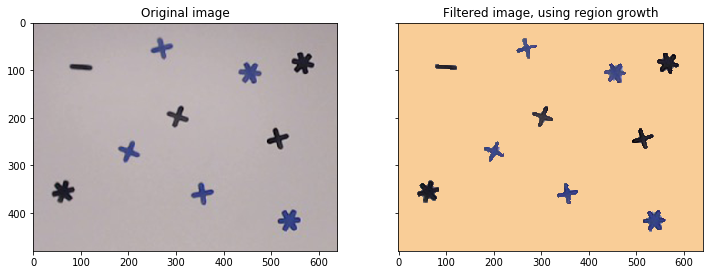

In [38]:
i = 0
img = images[0]
regions = []

img_hsv = rgb2hsv(img)
im = (img_hsv[:, :, 2]*255).astype(int)

THRESHOLD = 3
# segment the image
wid, hei = im.shape
for p_x, p_y in ((w, h) for w in range(img.shape[0]) for h in range(img.shape[1])):
    # if already part of a region, do nothing
    if part_of_region(regions, p_x, p_y) < 0:
        # else, build region
        regions.append({'label': len(regions), 'pixels': grow_region(im, p_x, p_y, 
                                                                     wid,hei, THRESHOLD, regions)})
        break # isolates background

mask = np.zeros(im.shape)
newimage = img.copy()

# generate the masks corresponding to the regions with seed = (150, 150)
for j,k in regions[0]['pixels']:
    mask[j][k] = 1
mask = mask > 0

# trim white border around objects
mask = ndi.binary_dilation(mask, iterations=3)

# vizualize the region generated
newimage[mask] = [249,205,151]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(newimage, cmap='gray')
axes[1].set_title('Filtered image, using region growth')
plt.show()

In [39]:
# flag to visualize regions
view_shapes = False

# get objects
structure = np.ones((3, 3), dtype=np.int)
labeled, nb_components = measurements.label((~mask).astype(int), structure)
indices = np.indices(mask.shape).T[:,:,[1, 0]]

all_objects = []
regions = []
masks = []
for i in range(1,nb_components+1):
    # get components' location
    component_pixels = indices[(labeled == i).T]
    
    if view_shapes:
        component_mask = np.zeros((img.shape[0], img.shape[1]))
        new_component_image = np.zeros(img.shape)
        
        # create mask
        for j,k in component_pixels:
            component_mask[k][j] = 1
        component_mask = component_mask > 0

        new_component_image[component_mask] = 250

        masks.append(component_mask)
        regions.append(new_component_image)
    
    # get objects' average color
    color_sum = np.zeros((1,3))
    for j,k in component_pixels:
        color_sum += img[k,j,:]
    all_objects.append({'id': i-1,
                        'pixels': component_pixels, 
                        'avg_color': color_sum[0]/len(component_pixels), 
                        'color_group': -1})
    
# view each shape's mask
if view_shapes:
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 4), sharey=True, sharex=True)
    for i in range(len(regions)):
        axes[int(i/5),i%5].imshow(regions[i], cmap='gray')

In [40]:
color_groups = []

def get_color_group(color_groups, obj, threshold = 15):
    obj_color = obj['avg_color']
    for color in color_groups:
        for member in color['avgs']:
            if ((abs(member[0] - obj_color[0]) < threshold) and
                (abs(member[1] - obj_color[1]) < threshold) and
                (abs(member[2] - obj_color[2]) < threshold)):
                return color['id']
    return -1

# group by color
for i in range(len(all_objects)):
    obj = all_objects[i]
    
    if obj['color_group'] == -1:
        if len(color_groups) == 0:
            # no existing colors, create first
            obj['color_group'] = 0
            color_groups.append({'id': 0, 
                                 'avgs': [obj['avg_color']], 
                                 'members': [obj['id']],
                                 'total_pixels': len(obj['pixels'])
                                })
        else:
            obj_group = get_color_group(color_groups, obj)
            if obj_group == -1:
                # no match anywhere, create new color group
                new_group_id = len(color_groups)
                obj['color_group'] = new_group_id
                color_groups.append({'id': new_group_id, 
                                     'avgs': [obj['avg_color']], 
                                     'members': [obj['id']],
                                     'total_pixels': len(obj['pixels'])
                                    })
            else:
                obj['color_group'] = obj_group
                color_groups[obj_group]['members'].append(obj['id'])
                color_groups[obj_group]['avgs'].append(obj['avg_color'])
                color_groups[obj_group]['total_pixels'] += len(obj['pixels'])
    
print("Identified color groups:")
for c in color_groups:
    print()
    for k, v in c.items():
        print(f"  \033[1m{k}\033[0m:\t{v}")

Identified color groups:

  id:	0
  avgs:	[array([ 74.17043741,  79.28205128, 127.46455505]), array([ 73.54312553,  77.90350128, 129.88556789]), array([ 70.21100917,  75.97116645, 128.91349934]), array([ 62.9599466 ,  68.56074766, 126.54072096]), array([ 59.69565217,  68.32648221, 127.69565217])]
  members:	[0, 2, 6, 8, 9]
  total_pixels:	4611

  id:	1
  avgs:	[array([36.43344426, 33.12312812, 42.14475874]), array([47.95264624, 44.23119777, 51.7994429 ]), array([62.08145363, 57.11403509, 65.31203008]), array([37.06826802, 32.67635904, 39.2642225 ]), array([42.87128713, 40.54379284, 48.6039604 ])]
  members:	[1, 3, 4, 5, 7]
  total_pixels:	4463


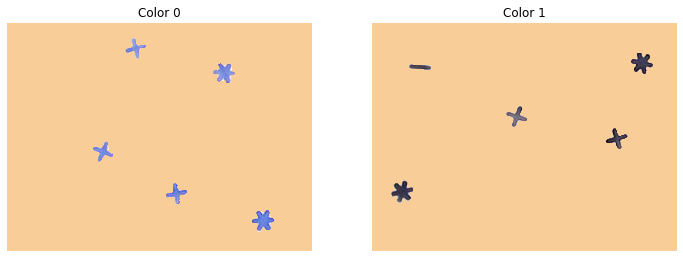

In [41]:
color_regions = []
for color_group in color_groups:
    
    color_mask = np.zeros((img.shape[0], img.shape[1]))
    new_component_image = images[1].copy()
    
    # create color mask
    for member_id in color_group['members']:
        member = all_objects[member_id]
        for j,k in member['pixels']:
            color_mask[k][j] = 1
    color_mask = color_mask > 0

    black = [249,205,151]
    new_component_image[~color_mask] = black
    color_regions.append(new_component_image)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True, sharex=True)
for i in range(len(color_regions)):
    axes[i].imshow(color_regions[i], cmap='gray')
    axes[i].set_title(f"Color {i}")
    axes[i].axis('off')

In [42]:
print(f"Number of colors: {len(color_groups)}")
for color in color_groups:
    print(f"Number of pixels in color {color['id']}: {color['total_pixels']}")

Number of colors: 2
Number of pixels in color 0: 4611
Number of pixels in color 1: 4463


<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 2.1.2 Contour Detection

Region growing showed promising results, but the contours of the shapes were not always very neatly segmented. Therefore, we attempt to detect the contours of the image first and then grow the background region to isolate the shapes. 

First, we test all contour detection methods as we did with the brain image. We do this on the green channel of the image because this causes the strongest difference in contours between the background and shapes. We use the second image as a prototype for this segmentation.

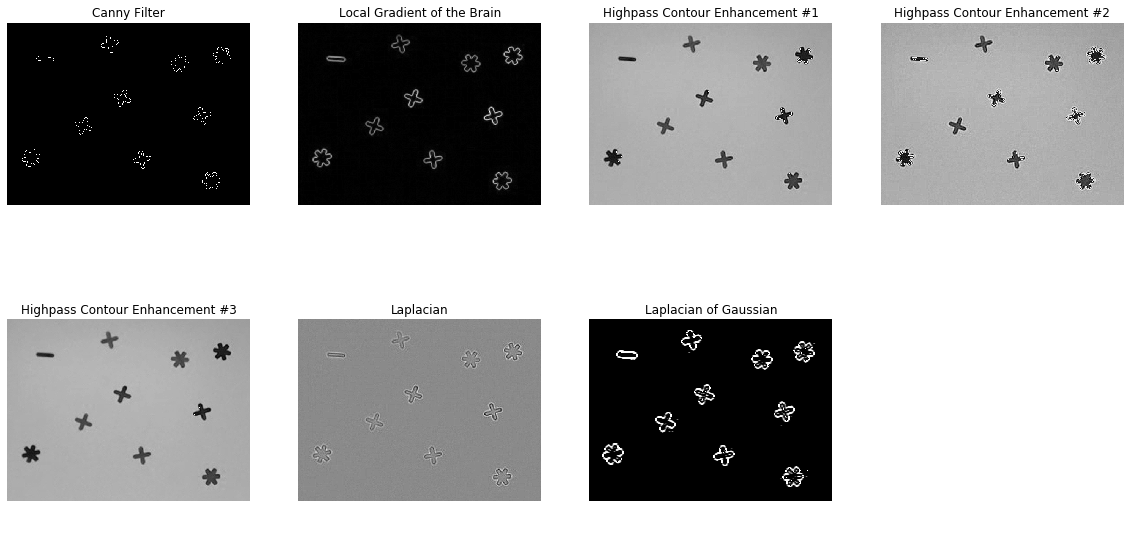

In [43]:
#Image 1
all_contour_detection(images[0, :, :, 1])

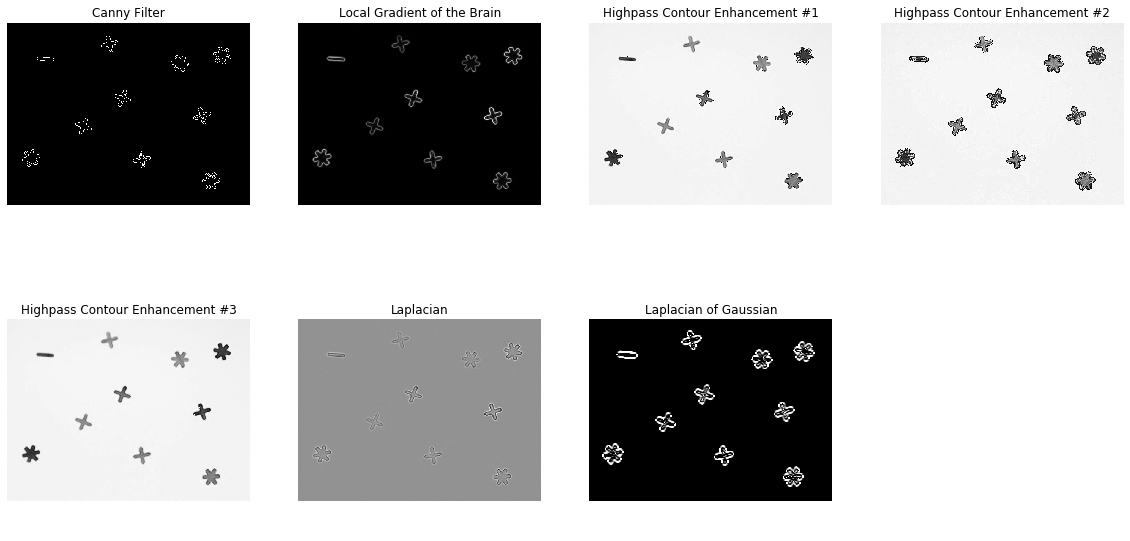

In [44]:
#Image 2
all_contour_detection(images[1, :, :, 1])

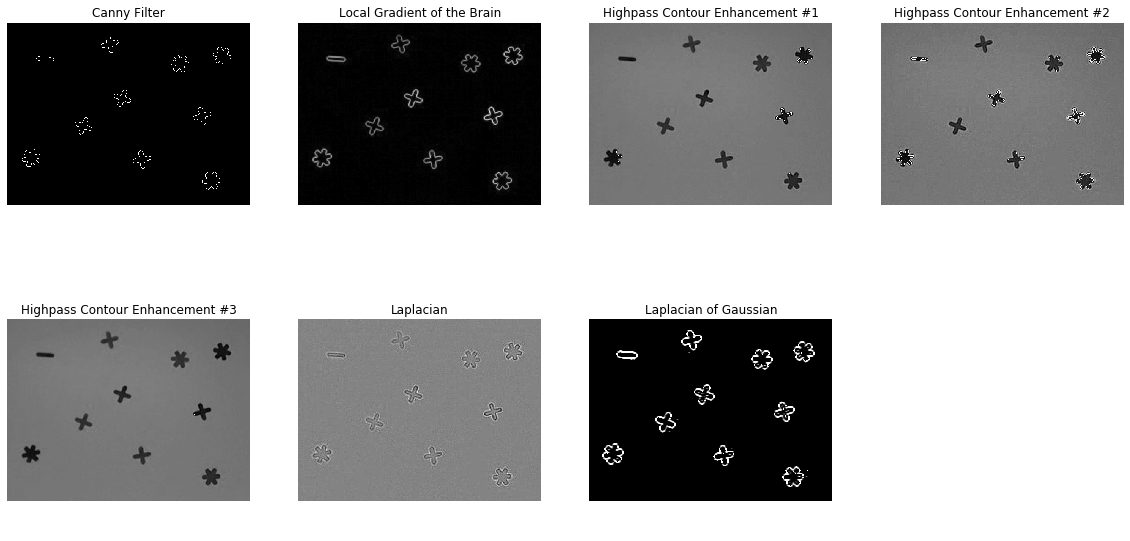

In [45]:
#Image 3
all_contour_detection(images[2, :, :, 1])

We can see that the local gradient shows distinct contours across all three images. Next, we threshold the contours in order to create a binary contour mask. Then, we region grow the background to detect the shapes. 

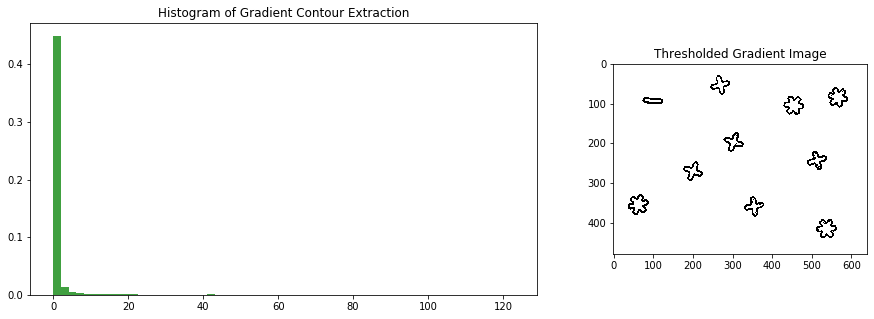

In [46]:
# apply thresholding on the gradient image to extract the contours
im0r = images[0, :, :, 1]
grad = filters.rank.gradient(skimage.util.img_as_ubyte(im0r), disk(1))

# apply thresholding to the sobel filtering contour extraction above
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})

n, bins, patches = axes[0].hist(grad.ravel(), 60, density=1, facecolor='green', alpha=0.75)
axes[0].set_title("Histogram of Gradient Contour Extraction")

img = (grad < 20)
axes[1].imshow(img, cmap='gray')
axes[1].set_title("Thresholded Gradient Image")
plt.show()

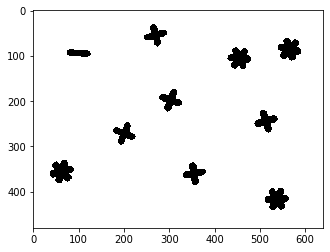

In [47]:
# region growing to detect background
mask_th = np.zeros(img.shape)
for i,j in grow_region(img, 1,1, img.shape[0],img.shape[1], 1, {}):
    mask_th[i][j] = 1
mask_th = mask_th > 0
plt.imshow(mask_th, cmap='gray')
plt.show()

As opposed to the first region growing example, this one depicts the objects as having clear borders. Next, we focus on the blue channel of the image to distinguish the blue from black images and we apply the shown mask on it. We then threshold each image with its respective mean blue value.

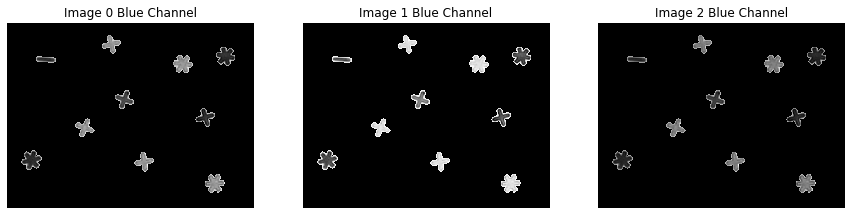

In [48]:
# set background pixels to zero
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1,1]})
imcopy = images.copy()
imcopy[:, mask_th, :] = 0
for i in range(0, 3):
    axes[i].imshow(imcopy[i, :, :, 2],cmap='gray')
    axes[i].set_title("Image {0} Blue Channel".format(i))
    axes[i].axis('off')

One can observe that mask includes objects as well as a thin border, from the background around them. This is because we performed contour detection and then region growing to make a mask, which increased the objects' boundaries' size. One of the challenges is also that the original images have average resolution and thus results are expected to be imperfect. Next, we threshold each image by its mean value to detect the blue objects.

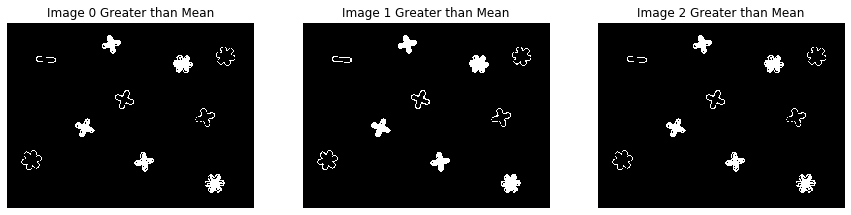

In [49]:
# threshold blue channel to detect blue vs grey pixels
im_blue = imcopy[:, :, :, 2]
means = np.zeros(3)
for i in range(0, 3):
    means[i] = np.mean(im_blue[i][im_blue[i] > 0])
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1,1]})
for i in range(0,3):
    axes[i].imshow(im_blue[i] > means[i],cmap='gray')
    axes[i].set_title("Image {0} Greater than Mean".format(i))
    axes[i].axis('off')

We can see that the blue objects are fully identified, while the black ones' contours are also identified. We now identify the blue objects as shapes containing more than 1000 pixels, and then the black objects are identified as regions that are not blue objects and not background.

In [50]:
thresholded_image = im_blue[1]>means[1]
labels = measure.label(thresholded_image)
label_counts = np.zeros(10)
for i in range(1, 11):
    label_counts[i-1] = np.sum(labels==i)

Number of blue objects: 5
Number of black objects: 5


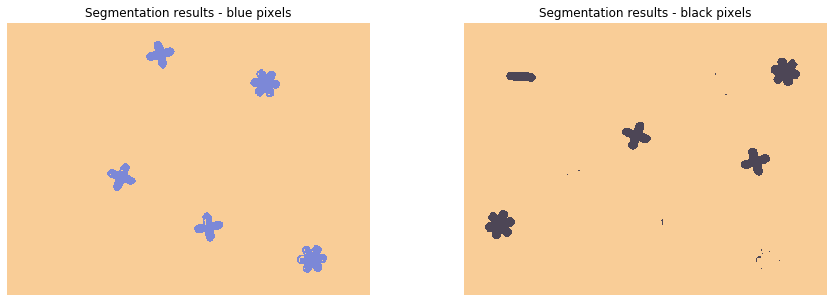

In [51]:
print("Number of blue objects: {0}".format(sum(label_counts>1000)))
labels_blue = labels.copy()
for label in (np.where(label_counts < 1000))[0]:
    labels_blue[labels == label+1] = 0
labels_blue[labels_blue != 0] = 1

print("Number of black objects: {0}".format(sum(label_counts<1000)))
labels_black = im_blue[1].copy()
labels_black[labels_blue == 1] = 0
labels_black[labels_black != 0] = 1
show_res_2fig([labels_blue,labels_black])

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

### 2.1.3 Histogram matching

The previous approach produced promising results across all three images, but there could be a more streamlined way of distinguishing blue from black objects. Methods such as thresholding and contour detection are specifically sensitive to illumination changes and we do not want to have to change method parameters (such as the threshold values) every time we have a new image with different brightness properties. 

In this section, we use histogram matching to adjust the pixel values of each image to match each other, thereby making the illumination of the images more similar and facilitating object detection. This method will make any previously presented method robust on each new image it is faced with.

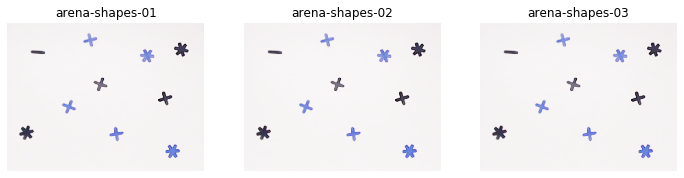

In [52]:
# perform histogram matching
out_img0 = np.zeros_like(images[0])
for c in range(0,3):
      out_img0[:, :, c] = hist_match(images[0][:, :, c], images[1][:, :, c])
        
out_img2 = np.zeros_like(images[0])
for c in range(0,3):
      out_img2[:, :, c] = hist_match(images[2][:, :, c], images[1][:, :, c])
        

normalized_images = np.zeros_like(images)
normalized_images[0] = out_img0
normalized_images[1] = images[1]
normalized_images[2] = out_img2

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), normalized_images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

img0 = normalized_images[0]
img1 = normalized_images[1]
img2 = normalized_images[2]

We have successfully made all shapes have a constant brightness and resemble each other strongly. Therefore, we use the first image as a prototype for all of the following functions, but this works with any of the three images due to their similarity. 

Now that we have normalized our images, let's try K-means clustering to label the objects in the image. K-means is the one of the basic and widely used clustering methods, which can also be applied in image segmentation and is implemented in the OpenCV library. We have color images, which provide more perspective for clustering; 3 channels means 3 features at our disposal. 

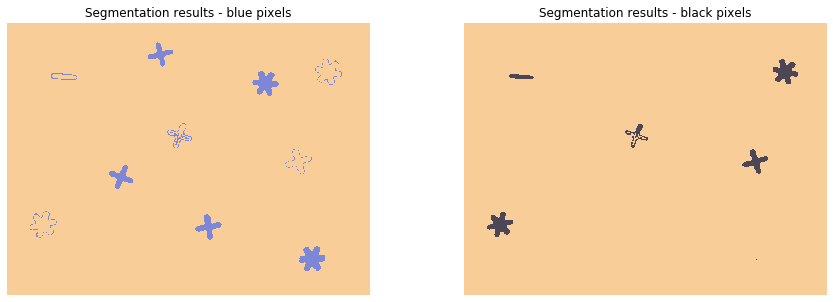

In [53]:
k = 3 # k for the k-means
pixel_values = img0.reshape((-1, 3))

# convert to float
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.02)
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(img0.shape)

m1 = np.zeros((480, 640), np.uint8)
m1[(segmented_image[:, :, 0] == 133)] = 1
m2 = np.zeros((480, 640), np.uint8)
m2[(segmented_image[:, :, 0] == 69)] = 1
#show_results2([m1,m2], ['kmeans'])

show_res_2fig([m1,m2])

This segmentation is not bad, except that edges of black objects are clustered in blue.

Next, we convert the image to HSV and we examine how can we use it to segment the objects.

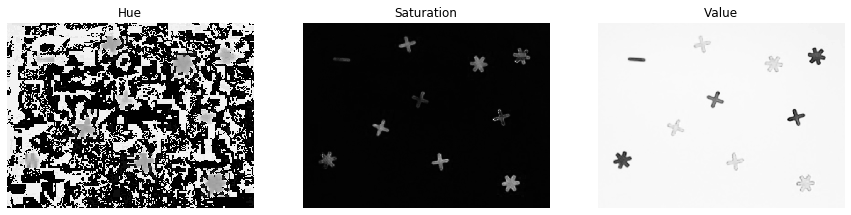

In [54]:
# convert to HSV
img_hsv = cv2.cvtColor(img0,cv2.COLOR_RGB2HSV)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1,1]})
titles=[[],[],[]]
titles[1]='Saturation'
titles[0]='Hue'
titles[2]='Value'
for i in range(0,3):
    axes[i].imshow(img_hsv[:,:,i],cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

By thresholding on the saturation (S) channel, we can expect to extract blue objects, but partially black as well. Thresholding on the value (V) channel will allow us detect black objects easily. 

Then we can apply simple rule: all that is detected (with thresholding) on the S channel and is not black (i.e. not detected on the V channel) is therefore blue.

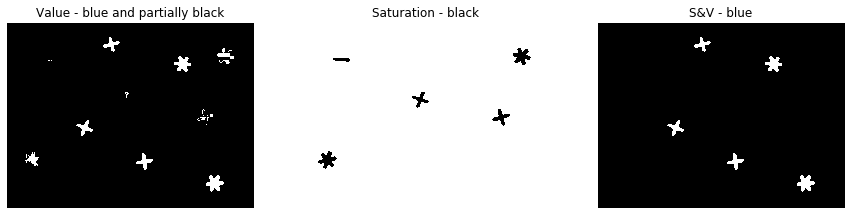

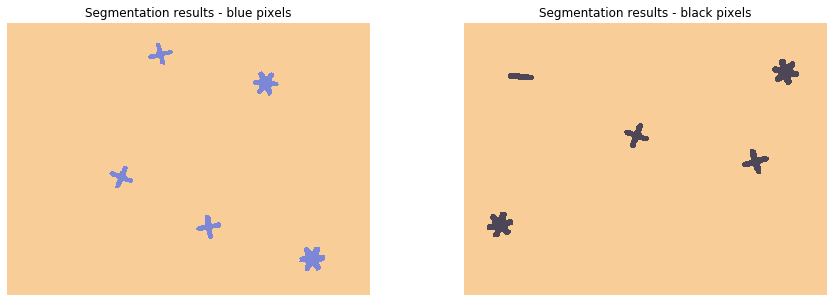

In [55]:
# thresholding saturation and value channels
r,th1 = cv2.threshold(img_hsv[:,:,1],60,255,cv2.THRESH_BINARY)
r,th2 = cv2.threshold(img_hsv[:,:,2],150,255,cv2.THRESH_BINARY)
result = (th1 & th2)

masks=[th1,th2,result]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1,1]})
titles=[[],[],[]]
titles[1]='Saturation - black'
titles[0]='Value - blue and partially black'
titles[2]='S&V - blue'
for i in range(0,3):
    axes[i].imshow(masks[i],cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')
# blue objects
result = (th1 & th2)

# black objects
r, th3 = cv2.threshold(img_hsv[:, :, 2], 200, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5), np.uint8)
result_black = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)

result[result==255] = 1
result_black[result_black==255] = 1
#show_results2([result, result_black], ['thresholding'])
show_res_2fig([result, result_black])

In the previous image, we see a successful segmentation in which the black and blue objects are well segmented, but they could be sharper. Thus, we will perform a combination of k-means clustering and thresholding to determine the optimal blue vs black object segmentation.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

Next, we perform K-means clusering to detect the objects. We will perform clustering two times - once for blue pixels (versus background), and another for black pixels, in order to avoid mixing blue/black objects and to try to obtain sharp edges. 

Before clustering, each color's binary mask will be dilated to expand into the regions around objects. This way we avoid possibly losing the sharpness of the objects' edges, and clustering makes more sense than the previously performed thresholding. 

We know that each object is inside the mask but we also expect the mask to include part of the background. This is why we are looking for 3 clusters (object inside mask, tiny region in the mask surrounding the object but belonging to background, and out-of-mask-background (regions that are black because of the mask)). 

In the first figures below we ilustrate how the input to the clustering algorithm looks, and in the second figure we show the final results. 

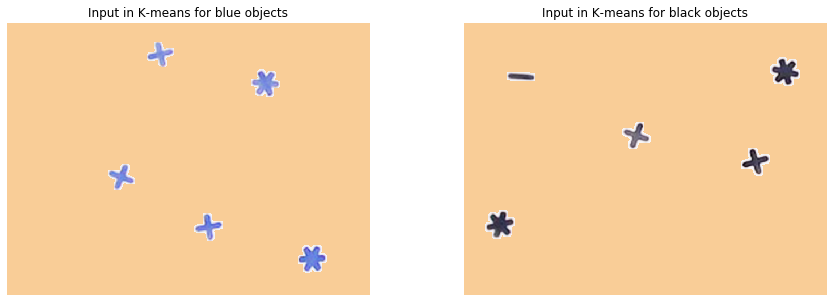

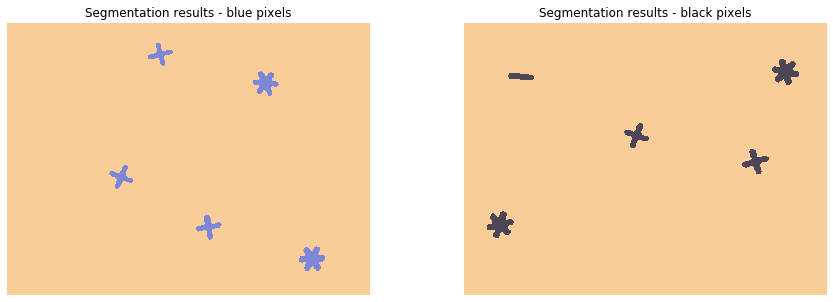

In [56]:
kernel = np.ones((3,3), np.uint8)
result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)
kernel = np.ones((7,7), np.uint8)
mask_blue = cv2.dilate(result, kernel, iterations=1)

kernel = np.ones((7,7), np.uint8)
mask_black = cv2.dilate(result_black, kernel, iterations=1)

# use blue and black masks from thresholding to make background peach-colored
th_blue = img0.copy()
th_blue[mask_blue==0, 0] = 249
th_blue[mask_blue==0, 1] = 205
th_blue[mask_blue==0, 2] = 151

th_black = img0.copy()
th_black[mask_black==0, 0] = 249
th_black[mask_black==0, 1] = 205
th_black[mask_black==0, 2] = 151

masks=[th_blue,th_black]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
titles=[[],[],[]]
titles[1]='Input in K-means for black objects'
titles[0]='Input in K-means for blue objects'
for i in range(0,2):
    axes[i].imshow(masks[i],cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')
    
    
# perform k-means segmentation on each color mask separately:
# blue k-means
segmented_image_blue = kmeas_clustering(th_blue)
indg = (segmented_image_blue[:, :, 1] == 224)
segmented_image_blue[indg, 0] = 249
segmented_image_blue[indg, 1] = 205
segmented_image_blue[indg, 2] = 151

indblue = (indg | (mask_blue==0))
mask1 = np.ones((480, 640), np.uint8)
mask1[indblue] = 0

# black k-means
segmented_image_black = kmeas_clustering(th_black)
indg = (segmented_image_black[:, :, 1] == 231)
segmented_image_black[indg, 0] = 249
segmented_image_black[indg, 1] = 205
segmented_image_black[indg, 2] = 151

indblack = (indg | (mask_black==0))
mask2 = np.ones((480, 640), np.uint8)
mask2[indblack] = 0

show_res_2fig([mask1, mask2])

Let us now visualize the diference between the last two methods.

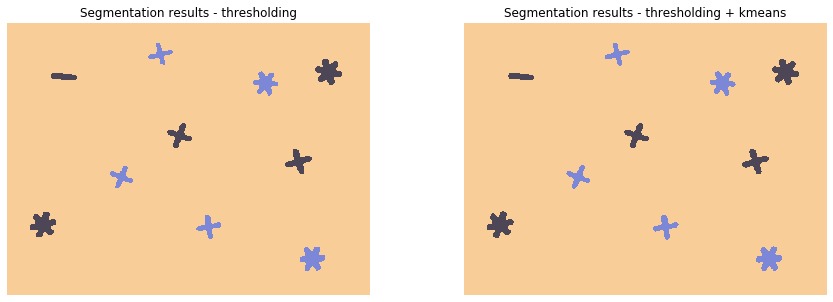

In [57]:
show_results2([result, result_black,mask1,mask2],['thresholding','thresholding + kmeans'])

We can see that both the `thresholding` and the `thresholding + k-means` segmentation approaches produce viable segmentations, successfully distinguishing between blue and black objects.

### 2.2 Number of shapes of each color

We use skimage's image segmentation `label` function applied to our blue and black object masks to determine the number of objects of each color. Here, we take the results obtained by `thresholding + k-means`. But as shown above, there are other methods that give the same results when it comes to number of objects.

In [58]:
labels_blue = measure.label(mask1)
print("Number of  blue objects: {0}".format(labels_blue.max()))

labels_black = measure.label(mask2)
print("Number of black objects: {0}".format(labels_black.max()))

Number of  blue objects: 5
Number of black objects: 5


<hr style="margin-bottom:40px">
<div style="background:#CCC; height:200%;"><h2 style="width: 100%; text-align: center; border-bottom: 1px solid #000; line-height: 0.1em; margin: 10px 0 20px;"><span style="background:#fff; padding:0 10px; border-radius: 8px;">As such, there are 5 blue shapes and 5 black shapes.</span></h2></div>
<hr style="margin-top:30px">

### 2.3 Total area (in pixels) of each color

We obtain the total areas for each color by counting the number of pixels in each color's mask. For our final estimate, we average the count from both the `thresholding` and the `thresholding + K-means` results.

In [59]:
# count the number of pixels of each color 
print(f"Number of pixels in  blue thresholding: {result.sum()}")
print(f"Number of pixels in  blue k-means     : {mask1.sum()}\n")

print(f"Number of pixels in black thresholding: {result_black.sum()}")
print(f"Number of pixels in black k-means     : {mask2.sum()}\n")

# average the values for both thresholding and k-means
print(f"\033[1mAverage number of pixels in  blue     : {round((result.sum() + mask1.sum())/2):.0f}\033[0m")
print(f"\033[1mAverage number of pixels in black     : {round((result_black.sum() + mask2.sum())/2):.0f}\033[0m")

Number of pixels in  blue thresholding: 4186
Number of pixels in  blue k-means     : 4402

Number of pixels in black thresholding: 4666
Number of pixels in black k-means     : 4699

Average number of pixels in  blue     : 4294
Average number of pixels in black     : 4682


<hr style="margin-bottom:40px">
<div style="background:#CCC; height:200%;"><h2 style="width: 100%; text-align: center; border-bottom: 1px solid #000; line-height: 0.1em; margin: 10px 0 20px;"><span style="background:#fff; padding:0 10px; border-radius: 8px;">As such, there is a total black area of 4682 pixels, and a blue one of 4294 pixels.</span></h2></div>